# **"Understanding Cab Services in NYC:** *An In-Depth Analysis of Usage, Impact, and Geospacial Trends*""

## 0. Import Libraries & Packages

In [1]:
### INSTALLING LIBRARIES ###

%pip install -q "dask[complete]" pyarrow fastparquet
%pip install -q graphviz ipycytoscape
%pip install -q pyspark findspark

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Impoerting libraries
import os
import sys
import time
import json
import gc
import warnings
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from dask.distributed import Client
from dask.distributed import LocalCluster
from pyspark.sql import SparkSession, SQLContext, Row, DataFrame, Column
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# Warning settings
warnings.filterwarnings("ignore")

# GC settings
gc.collect()

20

In [10]:
# Initialize Spark session
spark = SparkSession.builder.appName("CabServices")\
                                .config("spark.driver.memory", "14g")\
                                .config("spark.executor.memory", "14g")\
                                .config("spark.driver.maxResultSize", "8g")\
                                .config("spark.dynamicAllocation.enabled", "true") \
                                .config("spark.driver.extraJavaOptions", "-XX:ReservedCodeCacheSize=2024m") \
                                .config("spark.executor.extraJavaOptions", "-XX:ReservedCodeCacheSize==2024m").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

gc.collect()

23/12/07 18:10:27 WARN Utils: Your hostname, Hemanths-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.186 instead (on interface en0)
23/12/07 18:10:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/07 18:10:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/07 18:10:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


2693

### DATA Preparation ###

### i. Yellow Taxi Data Preparation

In [5]:
# Setting up Schema for yellow cabs
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, TimestampType

yellow_schema = StructType([
    StructField("VendorID", LongType(), True),
    StructField("tpep_pickup_datetime", TimestampType(), True),
    StructField("tpep_dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", DoubleType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("RatecodeID", DoubleType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("PULocationID", LongType(), True),
    StructField("DOLocationID", LongType(), True),
    StructField("payment_type", LongType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("congestion_surcharge", DoubleType(), True),
    StructField("airport_fee", IntegerType(), True)
])

# Function to compare schemas
def compare_schemas(schema1, schema2):
    return set(schema1.fieldNames()) == set(schema2.fieldNames())

# Directory containing Parquet files
directory_path = "data/raw/yellow/"

# List all Parquet files in the directory
parquet_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.parquet')]

# Missmatched Files
missmatched_files = []

# Check each file
for file_path in parquet_files:
    df = spark.read.parquet(file_path)
    if not compare_schemas(df.schema, yellow_schema):
        print(f"Schema mismatch found in file: {file_path}")
        # print("File Schema:")
        # df.printSchema()
        missmatched_files.append(file_path)

gc.collect()

Schema mismatch found in file: data/raw/yellow/yellow_tripdata_2023-06.parquet
Schema mismatch found in file: data/raw/yellow/yellow_tripdata_2023-07.parquet
Schema mismatch found in file: data/raw/yellow/yellow_tripdata_2023-05.parquet
Schema mismatch found in file: data/raw/yellow/yellow_tripdata_2023-04.parquet
Schema mismatch found in file: data/raw/yellow/yellow_tripdata_2023-08.parquet
Schema mismatch found in file: data/raw/yellow/yellow_tripdata_2023-09.parquet
Schema mismatch found in file: data/raw/yellow/yellow_tripdata_2023-02.parquet
Schema mismatch found in file: data/raw/yellow/yellow_tripdata_2023-03.parquet


456

In [6]:
yellow_cab_df = spark.read.format("parquet").option("inferSchema", "true").option("recursiveFileLookup", "true").load("data/raw/yellow/")

In [7]:
# count the number of rows in the dataframe
yellow_cab_df.count()

207879601

In [8]:
# Print the schema of the dataframe
from pyspark.sql.functions import lit

def align_schema(df, master_schema):
    # Add missing columns as nulls
    for field in master_schema.fields:
        if field.name not in df.columns:
            df = df.withColumn(field.name, lit(None).cast(field.dataType))
    # Select columns as per master schema and return
    return df.select([field.name for field in master_schema.fields])

In [ ]:
directory_path = "data/raw/yellow/"

# List all Parquet files in the directory
parquet_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.parquet')]

destination_directory_path = "data/prepared/yellow"

os.makedirs(destination_directory_path, exist_ok=True)

# Process each file
for file_name in parquet_files:
    df = spark.read.parquet(file_path)
    aligned_df = align_schema(df, yellow_schema)
    
    # Write to new location with the same file name
    destination_path = os.path.join(destination_directory_path, file_name.split("/")[-1])
    aligned_df.write.mode("overwrite").parquet(destination_path)

In [10]:
# List all Parquet files in the directory
yellow_cab_df = spark.read.format("parquet").option("inferSchema", "true").option("recursiveFileLookup", "true").load("data/prepared/yellow/")
yellow_cab_df.count()

194014662

### ii. Green Taxi Data Preparation

In [4]:
# Setting up Schema for green cabs
green_cab_df = spark.read.format("parquet").option("inferSchema", "true").option("recursiveFileLookup", "true").load("data/raw/green/")

In [5]:
# count the number of rows in the dataframe
green_cab_df.count()

10536961

In [6]:
# Print the schema of the dataframe
green_cab_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- lpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- lpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [7]:
# Setting up Schema for green cabs
green_schema = StructType([
    StructField("VendorID", LongType(), True),
    StructField("lpep_pickup_datetime", TimestampType(), True),
    StructField("lpep_dropoff_datetime", TimestampType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("RatecodeID", DoubleType(), True),
    StructField("PULocationID", LongType(), True),
    StructField("DOLocationID", LongType(), True),
    StructField("passenger_count", DoubleType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("ehail_fee", DoubleType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("payment_type", DoubleType(), True),
    StructField("trip_type", DoubleType(), True),
    StructField("congestion_surcharge", DoubleType(), True)
])

In [8]:
# Function to compare schemas
def compare_schemas(schema1, schema2):
    return set(schema1.fieldNames()) == set(schema2.fieldNames())

# Directory containing Parquet files
directory_path = "data/raw/green/"

# List all Parquet files in the directory
parquet_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.parquet')]

# Missmatched Files
missmatched_files = []

# Checking each file
for file_path in parquet_files:
    df = spark.read.parquet(file_path)
    if not compare_schemas(df.schema, green_schema):
        print(f"Schema mismatch found in file: {file_path}")
        # print("File Schema:")
        # df.printSchema()
        missmatched_files.append(file_path)

In [9]:
from pyspark.sql.functions import lit

def align_schema(df, master_schema):
    # Adding missing columns as nulls
    for field in master_schema.fields:
        if field.name not in df.columns:
            df = df.withColumn(field.name, lit(None).cast(field.dataType))
    # Select columns as per master schema and return
    return df.select([field.name for field in master_schema.fields])

In [10]:
directory_path = "data/raw/green/"

# List all Parquet files in the directory
parquet_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.parquet')]

destination_directory_path = "data/prepared/green"

# Ensure the destination directory exists
os.makedirs(destination_directory_path, exist_ok=True)

# Process each file
for file_name in parquet_files:
    df = spark.read.parquet(file_path)
    aligned_df = align_schema(df, green_schema)
    
    # Writing to new location with the same file name
    destination_path = os.path.join(destination_directory_path, file_name.split("/")[-1])
    aligned_df.write.mode("overwrite").parquet(destination_path)

gc.collect()

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=25803Kb max_used=25803Kb free=105268Kb
 bounds [0x000000010c9e0000, 0x000000010e340000, 0x00000001149e0000]
 total_blobs=10115 nmethods=9141 adapters=887
 compilation: disabled (not enough contiguous free space left)


790

In [11]:
# count the number of rows in the dataframe
green_cab_df = spark.read.format("parquet").option("inferSchema", "true").option("recursiveFileLookup", "true").load("data/prepared/green/")
green_cab_df.count()

36654591

### iii. Uber/lyft Data

In [51]:
# Reading the fhvhv cabs
uber_lyft_cab_df = spark.read.format("parquet").option("inferSchema", "true").option("recursiveFileLookup", "true").load("data/raw/fhvhv/")

In [52]:
uber_lyft_cab_df.count()

937471013

In [54]:
# print the schema of the dataframe
uber_lyft_cab_df.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_

In [56]:
# Setting up Schema for fhvhv cabs
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, LongType, DoubleType, IntegerType

uber_lyft_schema = StructType([
    StructField("hvfhs_license_num", StringType(), True),
    StructField("dispatching_base_num", StringType(), True),
    StructField("originating_base_num", StringType(), True),
    StructField("request_datetime", TimestampType(), True),
    StructField("on_scene_datetime", TimestampType(), True),
    StructField("pickup_datetime", TimestampType(), True),
    StructField("dropoff_datetime", TimestampType(), True),
    StructField("PULocationID", LongType(), True),
    StructField("DOLocationID", LongType(), True),
    StructField("trip_miles", DoubleType(), True),
    StructField("trip_time", LongType(), True),
    StructField("base_passenger_fare", DoubleType(), True),
    StructField("tolls", DoubleType(), True),
    StructField("bcf", DoubleType(), True),
    StructField("sales_tax", DoubleType(), True),
    StructField("congestion_surcharge", DoubleType(), True),
    StructField("airport_fee", IntegerType(), True),
    StructField("tips", DoubleType(), True),
    StructField("driver_pay", DoubleType(), True),
    StructField("shared_request_flag", StringType(), True),
    StructField("shared_match_flag", StringType(), True),
    StructField("access_a_ride_flag", StringType(), True),
    StructField("wav_request_flag", StringType(), True),
    StructField("wav_match_flag", IntegerType(), True)
])

In [58]:
# Function to compare schemas
def compare_schemas(schema1, schema2):
    return set(schema1.fieldNames()) == set(schema2.fieldNames())

# Directory containing Parquet files
directory_path = "data/raw/fhvhv/"

# List all Parquet files in the directory
parquet_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.parquet')]

# Missmatched Files
missmatched_files = []

# Check each file
for file_path in parquet_files:
    df = spark.read.parquet(file_path)
    if not compare_schemas(df.schema, uber_lyft_schema):
        print(f"Schema mismatch found in file: {file_path}")
        # print("File Schema:")
        # df.printSchema()
        missmatched_files.append(file_path)

In [59]:
from pyspark.sql.functions import lit

def align_schema(df, master_schema):
    # Add missing columns as nulls
    for field in master_schema.fields:
        if field.name not in df.columns:
            df = df.withColumn(field.name, lit(None).cast(field.dataType))
    # Select columns as per master schema and return
    return df.select([field.name for field in master_schema.fields])

In [62]:
directory_path = "data/raw/fhvhv/"

# List all Parquet files in the directory
parquet_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.parquet')]

destination_directory_path = "data/prepared/fhvhv"

# Ensure the destination directory exists
os.makedirs(destination_directory_path, exist_ok=True)

# Process each file
for file_name in parquet_files:
    df = spark.read.parquet(file_path)
    aligned_df = align_schema(df, uber_lyft_schema)
    
    # Write to new location with the same file name
    destination_path = os.path.join(destination_directory_path, file_name.split("/")[-1])
    aligned_df.write.mode("overwrite").parquet(destination_path)

gc.collect()

596

In [63]:
uber_lyft_cab_df = spark.read.format("parquet").option("inferSchema", "true").option("recursiveFileLookup", "true").load("data/prepared/fhvhv/")
uber_lyft_cab_df.count()

837865952

## **1. Data Exploration**

### i. Yellow Cab Data

In [22]:
# Reading the yellow cabs data
yellow_cab_df = spark.read.format("parquet").option("inferSchema", "true").option("recursiveFileLookup", "true").load("data/prepared/yellow/")

gc.collect()

204

In [23]:
yellow_cab_df.show(10)
gc.collect()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-03-01 00:06:43|  2023-03-01 00:16:43|              1|          0.0|         1|                 N|         238|          42|           2|        8.6|  1.0|    0.5|       0.

0

In [24]:
# Reading the yellow cabs data column names
yellow_cab_df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

In [25]:
# printing the schema of the dataframe
yellow_cab_df.printSchema()
gc.collect()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)



14

In [26]:
yellow_cab_df.count()

194014662

In [27]:
# updating the timestamp columns to unix timestamp
yellow_cab_df = yellow_cab_df.withColumn("pickup_datetime", unix_timestamp(col("tpep_pickup_datetime"), "yyyy-MM-dd HH:mm:ss"))
yellow_cab_df = yellow_cab_df.withColumn("dropoff_datetime", unix_timestamp(col("tpep_dropoff_datetime"), "yyyy-MM-dd HH:mm:ss"))
yellow_cab_df = yellow_cab_df.withColumn("trip_duration", (col("dropoff_datetime") - col("pickup_datetime"))/60)

In [28]:
# filtering the data
yellow_cab_df = yellow_cab_df.filter(
    (col("passenger_count") > 0) &
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0) &
    (col("total_amount") > 0)
)

In [29]:
yellow_cab_df = yellow_cab_df.filter(col("VendorID").isin([1, 2]))

In [30]:
# casting the columns
yellow_cab_df = yellow_cab_df \
    .withColumn("VendorID", col("VendorID").cast("integer")) \
    .withColumn("passenger_count", col("passenger_count").cast("double")) \
    .withColumn("PULocationID", col("PULocationID").cast("integer")) \
    .withColumn("DOLocationID", col("DOLocationID").cast("integer")) \
    .withColumn("payment_type", col("payment_type").cast("integer")) \
    .withColumn("RatecodeID", col("RatecodeID").cast("integer")) \
    .withColumn("store_and_fwd_flag", (col("store_and_fwd_flag") == "Y").cast("boolean"))

In [31]:
yellow_cab_df.count()

181866081

In [32]:
yellow_cab_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+----------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pickup_datetime|dropoff_datetime|     trip_duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+----------------+------------------+
|       2| 2023-03-01 00:08:25|

In [33]:
yellow_cab_df.describe(["passenger_count", "trip_distance", "fare_amount", "tip_amount", "extra", "mta_tax", "tolls_amount", "improvement_surcharge", "total_amount", "congestion_surcharge", "airport_fee"]).show()
gc.collect()

23/12/07 18:12:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+------------------+-----------------+--------------------+------------------+---------------------+------------------+--------------------+-----------+
|summary|   passenger_count|     trip_distance|      fare_amount|        tip_amount|            extra|             mta_tax|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|airport_fee|
+-------+------------------+------------------+-----------------+------------------+-----------------+--------------------+------------------+---------------------+------------------+--------------------+-----------+
|  count|         181866081|         181866081|        181866081|         181866081|        181866081|           181866081|         181866081|            181866081|         181866081|           181866081|          0|
|   mean|1.3771132562096613|3.5368336314451447|19.12731124827112|3.5418371620937013|1.671556719309311| 0.49741320922838833|0.5778057

191

In [34]:
# Droping the columns with airport fee
yellow_cab_df = yellow_cab_df.drop("airport_fee")

In [35]:
yellow_cab_df.show(10)

CodeCache: size=2072576Kb used=60916Kb max_used=62663Kb free=2011659Kb
 bounds [0x0000000280000000, 0x0000000283e00000, 0x00000002fe800000]
 total_blobs=18815 nmethods=17809 adapters=915
 compilation: disabled (not enough contiguous free space left)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---------------+----------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|pickup_datetime|dropoff_datetime|     trip_duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---------------+----------------+------------------+
|       2| 2023-03-01 00:08:25|  2023-03-01 00:39:30|            2.

In [78]:
#calculating the average trip duration of yellow cabs
from pyspark.sql.functions import unix_timestamp, avg

yellow_cab_df = yellow_cab_df.withColumn("trip_duration", (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))/60)
yellow_cab_df.select(avg("trip_duration")).show()
gc.collect()

+------------------+
|avg(trip_duration)|
+------------------+
| 16.97085293628852|
+------------------+



1586

In [27]:
# Defining the pickup hours
from pyspark.sql.functions import hour, count

yellow_cab_df.withColumn("pickup_hour", hour("tpep_pickup_datetime")).groupBy("pickup_hour").count().orderBy("pickup_hour").show()
gc.collect()

+-----------+--------+
|pickup_hour|   count|
+-----------+--------+
|          0| 4921665|
|          1| 3220614|
|          2| 1855977|
|          3| 1399749|
|          4|  897066|
|          5|  972648|
|          6| 2466789|
|          7| 5002662|
|          8| 6995895|
|          9| 7858647|
|         10| 8364123|
|         11| 9192219|
|         12| 9882774|
|         13|10048131|
|         14|10963095|
|         15|11134665|
|         16|11176959|
|         17|12427140|
|         18|13185240|
|         19|11855829|
+-----------+--------+
only showing top 20 rows



104

In [80]:
# ploting the pickup hours
from pyspark.sql.functions import hour, count
import plotly.graph_objects as go

# Group by pickup hour and count
hourly_counts = yellow_cab_df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                             .groupBy("pickup_hour") \
                             .count() \
                             .orderBy("pickup_hour") \
                             .collect()

# Separate the results into two lists for plotting
hours = [row['pickup_hour'] for row in hourly_counts]
counts = [row['count'] for row in hourly_counts]

# Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(x=hours, y=counts)
])

# Update the layout
fig.update_layout(
    title="Yellow Cab Trip Counts by Pickup Hour",
    xaxis_title="Hour of Day",
    yaxis_title="Number of Trips",
)

# Show the plot
fig.show()

In [28]:
# Grouping by the pickup location Id
yellow_cab_df.groupBy("PULocationID").count().orderBy("count", ascending=False).show(10)

+------------+-------+
|PULocationID|  count|
+------------+-------+
|         132|9215817|
|         161|8756283|
|         237|8369538|
|         236|7513341|
|         162|6841995|
|         230|6376419|
|         138|6364677|
|         186|6319305|
|         142|5951484|
|         170|5517942|
+------------+-------+
only showing top 10 rows



In [29]:
# counting the average ratecode id
yellow_cab_df.groupBy("RatecodeID").avg("fare_amount").orderBy("RatecodeID").show()

+----------+------------------+
|RatecodeID|  avg(fare_amount)|
+----------+------------------+
|         1|16.467196198044142|
|         2| 69.99387179886924|
|         3| 92.12528544737407|
|         4|110.83008547008535|
|         5| 89.73859907004636|
|        99|31.963307701849214|
+----------+------------------+



In [30]:
# count of payment types
yellow_cab_df.groupBy("payment_type").count().show()

+------------+---------+
|payment_type|    count|
+------------+---------+
|           1|149450295|
|           3|   631275|
|           4|  1072398|
|           2| 30712113|
+------------+---------+



In [31]:
# correlation between trip distance and fare amount
yellow_cab_df.stat.corr("trip_distance", "fare_amount")

0.15040814370019168

In [32]:
# seeing the passenger count and their average tip amount
yellow_cab_df.groupBy("passenger_count").avg("tip_amount").orderBy("passenger_count").show()

+---------------+------------------+
|passenger_count|   avg(tip_amount)|
+---------------+------------------+
|            1.0| 3.499225258552225|
|            2.0|3.7680295956781062|
|            3.0| 3.590185406077931|
|            4.0|3.4640151647811956|
|            5.0|3.4947571722421142|
|            6.0| 3.535952742325087|
|            7.0|14.049999999999988|
|            8.0| 8.754999999999997|
+---------------+------------------+



In [81]:
from pyspark.sql.functions import avg
import plotly.graph_objects as go

# Calculate the average tip amount by passenger count
avg_tip_by_passenger = yellow_cab_df.groupBy("passenger_count") \
                                    .agg(avg("tip_amount").alias("avg_tip")) \
                                    .orderBy("passenger_count") \
                                    .collect()

# Separate the results into two lists for plotting
passenger_counts = [row['passenger_count'] for row in avg_tip_by_passenger]
avg_tips = [row['avg_tip'] for row in avg_tip_by_passenger]

# Creating the Plotly plot
fig = go.Figure(data=[
    go.Bar(x=passenger_counts, y=avg_tips)
])

# Update the layout
fig.update_layout(
    title="Average Tip Amount by Passenger Count in Yellow Cabs",
    xaxis_title="Passenger Count",
    yaxis_title="Average Tip Amount ($)",
)

# Show the plot
fig.show()

In [33]:
yellow_cab_df.withColumn("toll_paid", (col("tolls_amount") > 0).cast("int")).groupBy("toll_paid").count().show()

+---------+---------+
|toll_paid|    count|
+---------+---------+
|        1| 14715120|
|        0|167150961|
+---------+---------+



In [34]:
from pyspark.sql.functions import dayofweek

yellow_cab_df.withColumn("day_of_week", dayofweek("tpep_pickup_datetime")).groupBy("day_of_week").avg("trip_distance").orderBy("day_of_week").show()

+-----------+------------------+
|day_of_week|avg(trip_distance)|
+-----------+------------------+
|          1| 3.971672787878557|
|          2|3.7660774537945314|
|          3|3.3698016529337114|
|          4| 3.446465562063614|
|          5|3.4386395878683342|
|          6| 3.671202089655777|
|          7| 3.209633700820875|
+-----------+------------------+



In [35]:
yellow_cab_df.select("fare_amount").rdd.flatMap(lambda x: x).histogram(10)

([0.01,
  95.99900000000001,
  191.988,
  287.977,
  383.966,
  479.95500000000004,
  575.944,
  671.933,
  767.922,
  863.9110000000001,
  959.9],
 [181255782, 548967, 46740, 10374, 2793, 570, 399, 342, 57, 57])

In [36]:
yellow_cab_df.groupBy("VendorID").count().show()

+--------+---------+
|VendorID|    count|
+--------+---------+
|       1| 48232431|
|       2|133633650|
+--------+---------+



In [37]:
yellow_cab_df.groupBy("PULocationID").agg(max("fare_amount"), min("fare_amount"), avg("fare_amount")).show()

+------------+----------------+----------------+------------------+
|PULocationID|max(fare_amount)|min(fare_amount)|  avg(fare_amount)|
+------------+----------------+----------------+------------------+
|         148|           203.2|            0.01|17.099946684005296|
|         243|           109.8|             3.0| 25.66090909090908|
|          31|            75.8|            12.8|              38.3|
|         137|           242.4|             3.0|14.540516171364516|
|          85|            49.5|             3.0| 25.35308641975312|
|         251|            73.0|            0.01|23.653333333333343|
|          65|           154.2|             3.0|24.537386569872968|
|         255|           110.0|             3.0| 20.80474137931032|
|          53|            70.0|             4.4|35.055555555555564|
|         133|           416.0|            0.01| 37.40694915254233|
|          78|            83.5|            10.0|29.469230769230766|
|         155|            73.5|             3.0|

In [83]:
# setting the schema for taxi zones
schema = StructType([
    StructField("LocationID", IntegerType(), True),
    StructField("Borough", StringType(), True),
    StructField("Zone", StringType(), True),
    StructField("service_zone", StringType(), True)
])

# Load the CSV file
taxi_zone_lookup_df = spark.read.csv(
    "taxi_zones/taxi+_zone_lookup.csv",
    header=True,  # Assumes the first row is a header
    schema=schema  # Use the defined schema
)

# Show the first few rows of the DataFrame
taxi_zone_lookup_df.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [90]:
# pick up location id and their average fare amount
from pyspark.sql.functions import max, min, avg
import plotly.graph_objects as go

# Step 1: Aggregate fare amount by PULocationID
fare_stats_df = yellow_cab_df.groupBy("PULocationID") \
                             .agg(max("fare_amount").alias("max_fare"),
                                  min("fare_amount").alias("min_fare"),
                                  avg("fare_amount").alias("avg_fare"))

# Step 2: Join with taxi_zone_lookup_df
joined_df = fare_stats_df.join(taxi_zone_lookup_df, fare_stats_df.PULocationID == taxi_zone_lookup_df.LocationID, "inner")

# Step 3: Select top 10 locations based on highest average fare
top_10_locations = joined_df.orderBy("avg_fare", ascending=False).limit(10)

# Collect the data for plotting
top_10_data = top_10_locations.collect()

# Separate the results into lists for plotting
zones = [row['Zone'] for row in top_10_data]
max_fares = [row['max_fare'] for row in top_10_data]
min_fares = [row['min_fare'] for row in top_10_data]
avg_fares = [row['avg_fare'] for row in top_10_data]

# Step 4: Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(name='Max Fare', x=zones, y=max_fares),
    go.Bar(name='Min Fare', x=zones, y=min_fares),
    go.Bar(name='Avg Fare', x=zones, y=avg_fares)
])

# Update the layout
fig.update_layout(
    title="Top 10 PickUP Locations by Average Fare Amount",
    xaxis_title="Zone",
    yaxis_title="Fare Amount ($)",
    barmode='group'
)

# Show the plot
fig.show()

In [91]:
# Drop off location id and their average fare amount
from pyspark.sql.functions import max, min, avg
import plotly.graph_objects as go

# Step 1: Aggregate fare amount by PULocationID
fare_stats_df = yellow_cab_df.groupBy("DOLocationID") \
                             .agg(max("fare_amount").alias("max_fare"),
                                  min("fare_amount").alias("min_fare"),
                                  avg("fare_amount").alias("avg_fare"))

# Step 2: Join with taxi_zone_lookup_df
joined_df = fare_stats_df.join(taxi_zone_lookup_df, fare_stats_df.DOLocationID == taxi_zone_lookup_df.LocationID, "inner")

# Step 3: Select top 10 locations based on highest average fare
top_10_locations = joined_df.orderBy("avg_fare", ascending=False).limit(10)

# Collect the data for plotting
top_10_data = top_10_locations.collect()

# Separate the results into lists for plotting
zones = [row['Zone'] for row in top_10_data]
max_fares = [row['max_fare'] for row in top_10_data]
min_fares = [row['min_fare'] for row in top_10_data]
avg_fares = [row['avg_fare'] for row in top_10_data]

# Step 4: Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(name='Max Fare', x=zones, y=max_fares),
    go.Bar(name='Min Fare', x=zones, y=min_fares),
    go.Bar(name='Avg Fare', x=zones, y=avg_fares)
])

# Update the layout
fig.update_layout(
    title="Top 10 DropOff Locations by Average Fare Amount",
    xaxis_title="Zone",
    yaxis_title="Fare Amount ($)",
    barmode='group'
)

# Show the plot
fig.show()

In [38]:
yellow_cab_df.filter(col("passenger_count") == 0).count()

0

In [40]:
# vendorid and their total amount
yellow_cab_df.groupBy("VendorID").sum("total_amount").show()

+--------+--------------------+
|VendorID|   sum(total_amount)|
+--------+--------------------+
|       1|1.2936560120706367E9|
|       2|3.8370679745618124E9|
+--------+--------------------+



In [41]:
yellow_cab_df.filter(col("congestion_surcharge") > 0).count()

169330812

In [42]:
yellow_cab_df.groupBy("store_and_fwd_flag").count().show()

+------------------+---------+
|store_and_fwd_flag|    count|
+------------------+---------+
|              true|   844740|
|             false|181021341|
+------------------+---------+



In [43]:
# distance range and their average fare amount
yellow_cab_df.withColumn("distance_range", when(col("trip_distance") < 5, "Short").otherwise("Long")).groupBy("distance_range").avg("fare_amount", "tip_amount").show()


+--------------+------------------+------------------+
|distance_range|  avg(fare_amount)|   avg(tip_amount)|
+--------------+------------------+------------------+
|          Long|49.661773131753534|   8.1283477423241|
|         Short|12.836799119145818|2.5969539496287948|
+--------------+------------------+------------------+



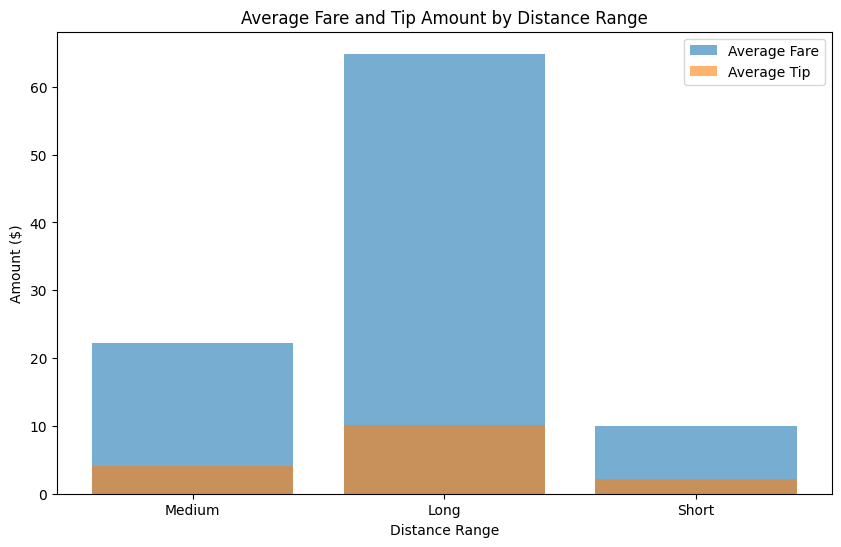

In [87]:
# Add a new column 'distance_range' with categories based on 'trip_distance'

from pyspark.sql.functions import col, when, avg
import matplotlib.pyplot as plt

# Add a new column 'distance_range' with categories based on 'trip_distance'
yellow_cab_df = yellow_cab_df.withColumn(
    "distance_range", 
    when(col("trip_distance") < 2, "Short")
    .when(col("trip_distance") < 10, "Medium")
    .otherwise("Long")
)

# Calculate the average fare and tip amounts for each distance range
distance_avg = yellow_cab_df.groupBy("distance_range") \
                            .agg(avg("fare_amount").alias("avg_fare"), 
                                 avg("tip_amount").alias("avg_tip")) \
                            .collect()

# Prepare data for plotting
distance_ranges = [row['distance_range'] for row in distance_avg]
avg_fares = [row['avg_fare'] for row in distance_avg]
avg_tips = [row['avg_tip'] for row in distance_avg]

# Plotting using PyPlot
plt.figure(figsize=(10, 6))
plt.bar(distance_ranges, avg_fares, alpha=0.6, label='Average Fare')
plt.bar(distance_ranges, avg_tips, alpha=0.6, label='Average Tip')

plt.xlabel('Distance Range')
plt.ylabel('Amount ($)')
plt.title('Average Fare and Tip Amount by Distance Range')
plt.legend()

plt.show()

In [89]:
from pyspark.sql.functions import when, col
import plotly.graph_objects as go

yellow_cab_df = yellow_cab_df.withColumn(
    "distance_range", 
    when(col("trip_distance") < 5, "Short")
    .when(col("trip_distance") < 10, "Medium")
    .otherwise("Long")
)

# Group by "distance_range" and calculate average "fare_amount" and "tip_amount"
agg_df = yellow_cab_df.groupBy("distance_range").avg("fare_amount", "tip_amount")

# Create the Plotly plot
fig = go.Figure()

# Add bar traces for "fare_amount" and "tip_amount"
for col_name in ["avg(fare_amount)", "avg(tip_amount)"]:
    fig.add_trace(
        go.Bar(
            x=agg_df.select("distance_range").rdd.map(lambda x: x[0]).collect(),
            y=agg_df.select(col_name).rdd.map(lambda x: x[0]).collect(),
            name=col_name.split("(")[1].split(")")[0],  # Extract column name from aggregation
        )
    )

# Update the layout
fig.update_layout(
    title="Average Fare Amount and Tip Amount by Distance Range",
    xaxis_title="Distance Range",
    yaxis_title="Average Amount",
)

# Show the plot
fig.show()

In [18]:
# Filter columns that are of numeric type
numeric_cols = [field.name for field in yellow_cab_df.schema.fields if isinstance(field.dataType, DoubleType)]

# Count nulls in numeric columns
null_counts = yellow_cab_df.select([count(when(col(c).isNull(), c)).alias(c) for c in numeric_cols]).show()

# Garbage collection
gc.collect()

+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------+
|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|trip_duration|
+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------+
|              0|            0|          0|    0|      0|         0|           0|                    0|           0|                   0|            0|
+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------+



191

### ii. Green Cab Data

In [36]:
# Reading the green cabs data
green_cab_df = spark.read.format("parquet").option("inferSchema", "true").option("recursiveFileLookup", "true").load("data/prepared/green/")

gc.collect()

58

In [37]:
green_cab_df.show(10)
gc.collect()

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       2| 2019-03-01 00:02:21|  2019-03-01 00:04:52|                 N|       1.0|         193|         193|            1.0|          0.0|        3.5|  0.5|    0.

0

In [38]:
# Displaying the columns of the dataframe
green_cab_df.columns

['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'ehail_fee',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge']

In [39]:
# printing the schema of the dataframe
green_cab_df.printSchema()
gc.collect()

root
 |-- VendorID: long (nullable = true)
 |-- lpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- lpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



14

In [40]:
green_cab_df.count()

36654591

In [41]:
green_cab_df = green_cab_df.withColumn("pickup_datetime", unix_timestamp(col("lpep_pickup_datetime"), "yyyy-MM-dd HH:mm:ss"))
green_cab_df = green_cab_df.withColumn("dropoff_datetime", unix_timestamp(col("lpep_dropoff_datetime"), "yyyy-MM-dd HH:mm:ss"))
green_cab_df = green_cab_df.withColumn("trip_duration", (col("dropoff_datetime") - col("pickup_datetime"))/60)

In [42]:
green_cab_df = green_cab_df.filter(
    (col("passenger_count") > 0) &
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0) &
    (col("total_amount") > 0) &
    (col("trip_type") > 0)
)

In [43]:
green_cab_df = green_cab_df.filter(col("VendorID").isin([1, 2]))

In [44]:
green_cab_df = green_cab_df \
    .withColumn("VendorID", col("VendorID").cast("integer")) \
    .withColumn("passenger_count", col("passenger_count").cast("integer")) \
    .withColumn("PULocationID", col("PULocationID").cast("integer")) \
    .withColumn("DOLocationID", col("DOLocationID").cast("integer")) \
    .withColumn("payment_type", col("payment_type").cast("integer")) \
    .withColumn("RatecodeID", col("RatecodeID").cast("integer")) \
    .withColumn("store_and_fwd_flag", (col("store_and_fwd_flag") == "Y").cast("boolean"))

In [45]:
green_cab_df.count()

33427365

In [46]:
green_cab_df.show(10)

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+---------------+----------------+------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|pickup_datetime|dropoff_datetime|     trip_duration|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+---------------+----------------+------------------+
|      

In [47]:
# calculating the summary of green cabs
green_cab_df.describe(["passenger_count", "trip_distance", "fare_amount", "tip_amount", "extra", "mta_tax", "tolls_amount", "improvement_surcharge", "total_amount", "congestion_surcharge", "ehail_fee"]).show()
gc.collect()

+-------+-----------------+-----------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+---------+
|summary|  passenger_count|    trip_distance|       fare_amount|        tip_amount|              extra|           mta_tax|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|ehail_fee|
+-------+-----------------+-----------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+---------+
|  count|         33427365|         33427365|          33427365|          33427365|           33427365|          33427365|          33427365|             33427365|          33427365|            33427365|        0|
|   mean| 1.30344192550026|3.527015184714665|14.246086623639956| 0.923468321837098|0.36314914442104546|0.4934744946243894|0.2554838390645295|   

191

In [48]:
green_cab_df = green_cab_df.drop("ehail_fee")

In [49]:
green_cab_df.show(10)

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+---------------+----------------+------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|pickup_datetime|dropoff_datetime|     trip_duration|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+---------------+----------------+------------------+
|       2| 2019-03-01 00:42:31|  2019

In [26]:
# calculating the average trip duration of green cabs
from pyspark.sql.functions import unix_timestamp, avg

green_cab_df = green_cab_df.withColumn("trip_duration", (unix_timestamp("lpep_dropoff_datetime") - unix_timestamp("lpep_pickup_datetime"))/60)
green_cab_df.select(avg("trip_duration")).show()
gc.collect()

+------------------+
|avg(trip_duration)|
+------------------+
|22.527995866243913|
+------------------+



119

In [27]:
# Defining the pickup hours
from pyspark.sql.functions import hour, count

green_cab_df.withColumn("pickup_hour", hour("lpep_pickup_datetime")).groupBy("pickup_hour").count().orderBy("pickup_hour").show()
gc.collect()

+-----------+-------+
|pickup_hour|  count|
+-----------+-------+
|          0| 826215|
|          1| 597189|
|          2| 390849|
|          3| 347415|
|          4| 317775|
|          5| 282093|
|          6| 536427|
|          7|1086078|
|          8|1672095|
|          9|1834830|
|         10|1786266|
|         11|1736220|
|         12|1733427|
|         13|1697460|
|         14|1856319|
|         15|1998990|
|         16|2150382|
|         17|2305650|
|         18|2362992|
|         19|2064939|
+-----------+-------+
only showing top 20 rows



90

In [28]:
# Defining the pulocation id
green_cab_df.groupBy("PULocationID").count().orderBy("count", ascending=False).show(10)

+------------+-------+
|PULocationID|  count|
+------------+-------+
|          74|2348799|
|          75|1985310|
|          41|1917309|
|           7|1339215|
|          82|1338075|
|         166|1267509|
|          42|1203384|
|          95| 968715|
|          97| 910005|
|         129| 854829|
+------------+-------+
only showing top 10 rows



In [29]:
# Defining the ratecode id
green_cab_df.groupBy("RatecodeID").avg("fare_amount").orderBy("RatecodeID").show()

+----------+------------------+
|RatecodeID|  avg(fare_amount)|
+----------+------------------+
|         1|12.860016890315606|
|         2|              52.0|
|         3|  65.4874213836478|
|         4|  64.5037688442211|
|         5|28.071918059558218|
|         6|               2.5|
+----------+------------------+



In [30]:
# Defining the payment type
green_cab_df.groupBy("payment_type").count().show()

+------------+--------+
|payment_type|   count|
+------------+--------+
|           1|20195157|
|           3|   71421|
|           5|     627|
|           4|   37848|
|           2|13137645|
+------------+--------+



In [31]:
# Defining the correlation between trip distance and fare amount
green_cab_df.stat.corr("trip_distance", "fare_amount")

0.936252193648369

In [32]:
# Defining the passenger count and their average tip amount
green_cab_df.groupBy("passenger_count").avg("tip_amount").orderBy("passenger_count").show()

+---------------+-------------------+
|passenger_count|    avg(tip_amount)|
+---------------+-------------------+
|              1|  0.913700008458385|
|              2|  1.001756637694953|
|              3| 0.8084394989339031|
|              4| 0.9203108985309106|
|              5| 1.0848430883462419|
|              6| 0.9230524495677354|
|              7|                0.0|
|              8| 2.2857142857142856|
|              9|0.04000000000000001|
+---------------+-------------------+



In [34]:
# toll paid and their count
green_cab_df.withColumn("toll_paid", (col("tolls_amount") > 0).cast("int")).groupBy("toll_paid").count().show()

+---------+--------+
|toll_paid|   count|
+---------+--------+
|        1| 1471569|
|        0|31971129|
+---------+--------+



In [36]:
# Defining the day of the week
from pyspark.sql.functions import dayofweek

green_cab_df.withColumn("day_of_week", dayofweek("lpep_pickup_datetime")).groupBy("day_of_week").avg("trip_distance").orderBy("day_of_week").show()

+-----------+------------------+
|day_of_week|avg(trip_distance)|
+-----------+------------------+
|          1|3.5151776825307923|
|          2|3.6363690013066385|
|          3| 3.612460981496478|
|          4|3.6118785939234983|
|          5|3.5717518401682153|
|          6| 3.453451435959459|
|          7|3.3686459294719224|
+-----------+------------------+



In [37]:
green_cab_df.select("fare_amount").rdd.flatMap(lambda x: x).histogram(10)

([0.01,
  64.509,
  129.00799999999998,
  193.50699999999998,
  258.006,
  322.505,
  387.00399999999996,
  451.50299999999993,
  516.002,
  580.501,
  645.0],
 [33214755, 222585, 4161, 855, 114, 57, 57, 0, 57, 57])

In [38]:
green_cab_df.groupBy("VendorID").count().show()

+--------+--------+
|VendorID|   count|
+--------+--------+
|       1| 4902000|
|       2|28540698|
+--------+--------+



In [39]:
# Defining the pulocation id and their average fare amount
green_cab_df.groupBy("PULocationID").agg(max("fare_amount"), min("fare_amount"), avg("fare_amount")).show()

+------------+----------------+----------------+------------------+
|PULocationID|max(fare_amount)|min(fare_amount)|  avg(fare_amount)|
+------------+----------------+----------------+------------------+
|         148|            13.5|            13.5|              13.5|
|         243|            88.0|             2.5| 16.59353331123633|
|          31|            99.5|             2.5|22.614836956521742|
|          85|            94.0|             2.5|22.012560975609727|
|         251|            64.0|            32.5| 44.17333333333333|
|         137|            41.0|            21.5|31.333333333333332|
|          65|           120.0|             2.5|13.590218424962801|
|         255|           150.0|             2.5|12.787586355321215|
|          53|           75.66|             3.5|29.386904761904788|
|         133|           72.31|             2.5|20.136661654135303|
|          78|            90.0|            0.01|20.279595375722575|
|         108|            91.0|             2.5|

In [42]:
green_cab_df.groupBy("VendorID").sum("total_amount").show()

+--------+-------------------+
|VendorID|  sum(total_amount)|
+--------+-------------------+
|       1|7.691023964954539E7|
|       2|4.870553225289128E8|
+--------+-------------------+



In [43]:
green_cab_df.filter(col("congestion_surcharge") > 0).count()

4220508

In [44]:
green_cab_df.groupBy("store_and_fwd_flag").count().show()

+------------------+--------+
|store_and_fwd_flag|   count|
+------------------+--------+
|              true|   53637|
|             false|33389061|
+------------------+--------+



In [45]:
green_cab_df.withColumn("distance_range", when(col("trip_distance") < 5, "Short").otherwise("Long")).groupBy("distance_range").avg("fare_amount", "tip_amount").show()


+--------------+-----------------+------------------+
|distance_range| avg(fare_amount)|   avg(tip_amount)|
+--------------+-----------------+------------------+
|          Long|32.27288000267531|1.3587343973382338|
|         Short|9.628400202953813| 0.812506213833203|
+--------------+-----------------+------------------+



In [50]:
# Filter columns that are of numeric type
numeric_cols = [field.name for field in green_cab_df.schema.fields if isinstance(field.dataType, DoubleType)]

# Count nulls in numeric columns
null_counts = green_cab_df.select([count(when(col(c).isNull(), c)).alias(c) for c in numeric_cols]).show()

# Garbage collection
gc.collect()

+-------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+--------------------+-------------+
|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_type|congestion_surcharge|trip_duration|
+-------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+--------------------+-------------+
|            0|          0|    0|      0|         0|           0|                    0|           0|        0|                   0|            0|
+-------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+--------------------+-------------+



224

In [92]:
# Average tip amount by passenger count
from pyspark.sql.functions import avg
import plotly.graph_objects as go

# Calculate the average tip amount by passenger count
avg_tip_by_passenger = green_cab_df.groupBy("passenger_count") \
                                    .agg(avg("tip_amount").alias("avg_tip")) \
                                    .orderBy("passenger_count") \
                                    .collect()

# Separate the results into two lists for plotting
passenger_counts = [row['passenger_count'] for row in avg_tip_by_passenger]
avg_tips = [row['avg_tip'] for row in avg_tip_by_passenger]

# Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(x=passenger_counts, y=avg_tips)
])

# Update the layout
fig.update_layout(
    title="Average Tip Amount by Passenger Count in Green Cabs",
    xaxis_title="Passenger Count",
    yaxis_title="Average Tip Amount ($)",
)

# Show the plot
fig.show()

### iii. Uber/Lyft Cab Data

In [50]:
# readig the data of fhvhv cabs
uber_lyft_cab_df = spark.read.format("parquet").option("inferSchema", "true").option("recursiveFileLookup", "true").load("data/prepared/fhvhv/")

gc.collect()

58

In [51]:
# displaying the data of fhvhv cabs
uber_lyft_cab_df.show(10)
gc.collect()

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+--

0

In [33]:
# displaying the columns of the dataframe
uber_lyft_cab_df.columns

['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag']

In [34]:
# printing the schema of the dataframe
uber_lyft_cab_df.printSchema()
gc.collect()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_f

14

In [35]:
uber_lyft_cab_df.count()

CodeCache: size=2072576Kb used=66135Kb max_used=66135Kb free=2006440Kb
 bounds [0x0000000280000000, 0x00000002840f0000, 0x00000002fe800000]
 total_blobs=19694 nmethods=18688 adapters=915
 compilation: disabled (not enough contiguous free space left)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


837865952

In [36]:
# calculating the summary of fhvhv cabs
numerical_cols = ['trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'tips', 'driver_pay']
uber_lyft_cab_df.describe(numerical_cols).show()

+-------+-----------------+------------------+-------------------+------------------+------------------+------------------+
|summary|       trip_miles|         trip_time|base_passenger_fare|             tolls|              tips|        driver_pay|
+-------+-----------------+------------------+-------------------+------------------+------------------+------------------+
|  count|        837865952|         837865952|          837865952|         837865952|         837865952|         837865952|
|   mean|4.902016162193814|1145.4322693948066| 23.783900115641664|0.9377160856365195|0.8825243652340288| 19.06058130012166|
| stddev|5.646516973814605| 833.9154790591797|   18.5736252341677|3.4785914797602584| 2.770543113128816|14.620392329854639|
|    min|              0.0|                 0|            -294.86|               0.0|               0.0|            -57.38|
|    max|           370.34|            240764|            1666.52|            152.66|             450.0|           1053.07|
+-------

In [73]:
# calculating the trip miles and trip time
uber_lyft_cab_df.select('trip_miles', 'trip_time').summary("count", "min", "25%", "50%", "75%", "max").show()

+-------+----------+---------+
|summary|trip_miles|trip_time|
+-------+----------+---------+
|  count| 837865952|837865952|
|    min|       0.0|        0|
|    25%|     1.655|      591|
|    50%|      3.03|      929|
|    75%|       6.0|     1449|
|    max|    370.34|   240764|
+-------+----------+---------+



In [75]:
# calculating the hour and their count
from pyspark.sql.functions import hour, dayofweek, month, year

uber_lyft_cab_df.withColumn("hour", hour("pickup_datetime")) \
  .groupBy("hour") \
  .count() \
  .orderBy("hour") \
  .show(24)


+----+--------+
|hour|   count|
+----+--------+
|   0|33721016|
|   1|24468360|
|   2|17754240|
|   3|12852784|
|   4|11175192|
|   5|13477128|
|   6|20256656|
|   7|29088360|
|   8|36836912|
|   9|37662912|
|  10|36531656|
|  11|36843296|
|  12|37580032|
|  13|38482248|
|  14|41648152|
|  15|43152424|
|  16|44185176|
|  17|46444160|
|  18|49749616|
|  19|49345968|
|  20|44842504|
|  21|45216640|
|  22|44820160|
|  23|41730360|
+----+--------+



In [76]:
#calculating the dispatching base number and their count
uber_lyft_cab_df.groupBy("dispatching_base_num").count().orderBy("count", ascending=False).show()

+--------------------+---------+
|dispatching_base_num|    count|
+--------------------+---------+
|              B02510|231074200|
|              B02764| 75884536|
|              B02872| 64612296|
|              B02875| 52359440|
|              B02765| 39087552|
|              B02869| 30391760|
|              B02866| 26196744|
|              B02887| 23005976|
|              B02682| 22923320|
|              B02871| 20989192|
|              B02864| 20158992|
|              B02878| 19962768|
|              B02617| 18332832|
|              B02883| 17709944|
|              B02884| 17343648|
|              B02882| 16535456|
|              B02876| 16044448|
|              B02835| 14351008|
|              B02879| 14315616|
|              B02877| 14012264|
+--------------------+---------+
only showing top 20 rows



In [77]:
# calculation the pulocationid Dolocationid and their count
uber_lyft_cab_df.groupBy("PULocationID", "DOLocationID").count().orderBy("count", ascending=False).show()

+------------+------------+-------+
|PULocationID|DOLocationID|  count|
+------------+------------+-------+
|          76|          76|2683856|
|         132|         265|1753976|
|          39|          39|1580880|
|          61|          61|1412096|
|          26|          26|1387568|
|          14|          14|1111320|
|         138|         265|1085392|
|           7|           7|1000720|
|          37|          37| 977760|
|         129|         129| 960456|
|         216|         216| 866432|
|          36|          37| 780080|
|          42|          42| 775656|
|          37|          36| 771792|
|          89|          89| 757904|
|          95|          95| 746032|
|         188|          61| 705544|
|           7|         223| 702296|
|         181|         181| 693560|
|          61|         225| 677600|
+------------+------------+-------+
only showing top 20 rows



In [50]:
# Load the CSV file for taxi zone lookup
schema = StructType([
    StructField("LocationID", IntegerType(), True),
    StructField("Borough", StringType(), True),
    StructField("Zone", StringType(), True),
    StructField("service_zone", StringType(), True)
])

taxi_zone_lookup_df = spark.read.csv(
    "taxi_zones/taxi+_zone_lookup.csv",
    header=True,
    schema=schema
)

# Group and aggregate data by Pickup and Dropoff Location IDs
agg_df = uber_lyft_cab_df.groupBy("PULocationID", "DOLocationID").count().orderBy("count", ascending=False)

# Extract the necessary columns for plotting
pickup_location_ids = agg_df.select("PULocationID").rdd.flatMap(lambda x: x).collect()
dropoff_location_ids = agg_df.select("DOLocationID").rdd.flatMap(lambda x: x).collect()
trip_counts = agg_df.select("count").rdd.flatMap(lambda x: x).collect()

# Create a scatter plot
fig = go.Figure(data=go.Scattergl(
    x=pickup_location_ids,
    y=dropoff_location_ids,
    mode='markers',
    marker=dict(
        size=trip_counts,
        color=trip_counts,
        colorscale='Viridis',
        showscale=True
    ),
    text=trip_counts
))

# Set axis labels and plot title
fig.update_xaxes(title_text="Pickup Location ID")
fig.update_yaxes(title_text="Dropoff Location ID")
fig.update_layout(title="Trip Counts by Pickup and Dropoff Location")

# Show the plot
fig.show()

In [78]:
uber_lyft_cab_df.select('base_passenger_fare').summary("count", "min", "25%", "50%", "75%", "max").show()

+-------+-------------------+
|summary|base_passenger_fare|
+-------+-------------------+
|  count|          837865952|
|    min|            -294.86|
|    25%|              12.29|
|    50%|              18.98|
|    75%|              29.32|
|    max|            1666.52|
+-------+-------------------+



In [79]:
uber_lyft_cab_df.select('tips').summary("count", "min", "25%", "50%", "75%", "max").show()

+-------+---------+
|summary|     tips|
+-------+---------+
|  count|837865952|
|    min|      0.0|
|    25%|      0.0|
|    50%|      0.0|
|    75%|      0.0|
|    max|    450.0|
+-------+---------+



In [80]:
print("Correlation between trip distance and fare: ", uber_lyft_cab_df.stat.corr("trip_miles", "base_passenger_fare"))

Correlation between trip distance and fare:  0.8523820712429944


In [81]:
uber_lyft_cab_df.withColumn("hour", hour("pickup_datetime")) \
  .groupBy("hour") \
  .count() \
  .orderBy("count", ascending=False) \
  .show()

+----+--------+
|hour|   count|
+----+--------+
|  18|49749616|
|  19|49345968|
|  17|46444160|
|  21|45216640|
|  20|44842504|
|  22|44820160|
|  16|44185176|
|  15|43152424|
|  23|41730360|
|  14|41648152|
|  13|38482248|
|   9|37662912|
|  12|37580032|
|  11|36843296|
|   8|36836912|
|  10|36531656|
|   0|33721016|
|   7|29088360|
|   1|24468360|
|   6|20256656|
+----+--------+
only showing top 20 rows



In [82]:
uber_lyft_cab_df.groupBy("shared_request_flag").count().show()

+-------------------+---------+
|shared_request_flag|    count|
+-------------------+---------+
|                  Y|   373408|
|                  N|837492544|
+-------------------+---------+



In [83]:
uber_lyft_cab_df.groupBy("access_a_ride_flag", "wav_request_flag").count().show()

+------------------+----------------+---------+
|access_a_ride_flag|wav_request_flag|    count|
+------------------+----------------+---------+
|                  |               Y|  1012424|
|                 N|               Y|   279160|
|                  |               N|600841416|
|                 N|               N|235732952|
+------------------+----------------+---------+



In [84]:
uber_lyft_cab_df.filter(uber_lyft_cab_df.airport_fee > 0).count()

44938656

In [85]:
uber_lyft_cab_df.groupBy("congestion_surcharge").count().show()

+--------------------+---------+
|congestion_surcharge|    count|
+--------------------+---------+
|                 0.0|515178720|
|                2.75|319710664|
|                 5.5|  2976456|
|                11.0|       56|
|                8.25|       56|
+--------------------+---------+



In [86]:
uber_lyft_cab_df.select('driver_pay').summary("count", "min", "25%", "50%", "75%", "max").show()

+-------+----------+
|summary|driver_pay|
+-------+----------+
|  count| 837865952|
|    min|    -57.38|
|    25%|      9.59|
|    50%|     15.42|
|    75%|     23.94|
|    max|   1053.07|
+-------+----------+



In [9]:
# Filtering columns that are of numeric type
numeric_cols = [field.name for field in uber_lyft_cab_df.schema.fields if isinstance(field.dataType, DoubleType) | isinstance(field.dataType, LongType) | isinstance(field.dataType, StringType)]

# Counting nulls in numeric columns
null_counts = uber_lyft_cab_df.select([count(when(col(c).isNull(), c)).alias(c) for c in numeric_cols]).show()

# Garbage collection
gc.collect()

+-----------------+--------------------+--------------------+------------+------------+----------+---------+-------------------+-----+---+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls|bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|
+-----------------+--------------------+--------------------+------------+------------+----------+---------+-------------------+-----+---+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|                0|                   0|           235785368|           0|           0|         0|        0|                  0|    0|  0| 

437

In [11]:
# Average tip amount by passenger count
uber_lyft_cab_df.withColumn("hour", hour("pickup_datetime")) \
  .groupBy("hour") \
  .agg({"trip_miles": "mean", "base_passenger_fare": "mean"}) \
  .orderBy("hour") \
  .show()

+----+------------------------+------------------+
|hour|avg(base_passenger_fare)|   avg(trip_miles)|
+----+------------------------+------------------+
|   0|      24.199072108625987| 5.040826240822681|
|   1|      23.142069804435327| 5.068389442365574|
|   2|      23.815441269238665| 5.124706636386536|
|   3|      24.140325993184266| 5.468473814233545|
|   4|      27.517163116301916| 6.453918629764922|
|   5|      25.892249992727344| 7.122430606283492|
|   6|        25.9145120063261| 6.724599829705375|
|   7|       24.57586263921674| 5.637587085968459|
|   8|      23.541219196662016|4.8680609362695915|
|   9|       21.30654996194013|  4.73249088100249|
|  10|       21.35163087050135|  4.78768483531105|
|  11|       22.16052175354056| 4.789445654156486|
|  12|      23.474080635167336| 4.814702134793255|
|  13|       24.59812632152296| 4.796866978665072|
|  14|      25.571008636354012| 4.701988558820076|
|  15|       25.75155049644959| 4.629402729635759|
|  16|       25.62554626556709|

In [13]:
uber_lyft_cab_df.groupBy("PULocationID").count().orderBy("count", ascending=False).show()

+------------+--------+
|PULocationID|   count|
+------------+--------+
|          61|12951624|
|          79|12389664|
|         132|10576552|
|          37|10524024|
|          76|10459680|
|         231| 9203264|
|         138| 9049376|
|         234| 8900472|
|         249| 8663088|
|           7| 8539608|
|         148| 8457120|
|          68| 8269688|
|          42| 8198512|
|         255| 8046248|
|         181| 8041264|
|         225| 7919912|
|          48| 7818216|
|         246| 7808136|
|          17| 7751968|
|         170| 7721224|
+------------+--------+
only showing top 20 rows



In [15]:
# showing the complete data of fhvhv cabs
uber_lyft_cab_df.show(10)

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+--

# 2. Data Cleaning

### i. Uber/Lyft Data

In [52]:
# Droping the columns
uber_lyft_cab_df = uber_lyft_cab_df.drop("originating_base_num", "on_scene_datetime", "shared_match_flag", "wav_match_flag", "shared_request_flag", "access_a_ride_flag", "wav_request_flag", "bcf")

In [53]:
uber_lyft_cab_df.show(10)

+-----------------+--------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+---------+--------------------+-----------+----+----------+
|hvfhs_license_num|dispatching_base_num|   request_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|
+-----------------+--------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+---------+--------------------+-----------+----+----------+
|           HV0003|              B02764|2021-05-31 23:53:49|2021-06-01 00:02:41|2021-06-01 00:07:46|         174|          18|       1.0|      305|               8.13|  0.0|     0.72|                 0.0|        0.0| 0.0|      7.03|
|           HV0003|              B02764|2021-06-01 00:08:40|2021-06-

In [54]:
from pyspark.sql.functions import col

# Filtering out negative values in trip_time, trip_miles, and base_passenger_fare
uber_lyft_cab_df = uber_lyft_cab_df.filter(
    (col('trip_time') >= 0) &
    (col('trip_miles') >= 0) &
    (col('base_passenger_fare') >= 0)
)

# Filtering out negative values in tolls and tips
uber_lyft_cab_df = uber_lyft_cab_df.filter(
    (col('tolls') >= 0) &
    (col('tips') >= 0)
)

# Show results
uber_lyft_cab_df.show()

+-----------------+--------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+---------+--------------------+-----------+----+----------+
|hvfhs_license_num|dispatching_base_num|   request_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|
+-----------------+--------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+---------+--------------------+-----------+----+----------+
|           HV0003|              B02764|2021-05-31 23:53:49|2021-06-01 00:02:41|2021-06-01 00:07:46|         174|          18|       1.0|      305|               8.13|  0.0|     0.72|                 0.0|        0.0| 0.0|      7.03|
|           HV0003|              B02764|2021-06-01 00:08:40|2021-06-

In [31]:
# Adding hour column
df_with_hour = uber_lyft_cab_df.withColumn("hour", hour(uber_lyft_cab_df.pickup_datetime))

# Trip volumes by hour
hourly_trip_volumes = df_with_hour.groupBy("hour").count().orderBy("hour")

# Average trip duration by hour
hourly_avg_duration = df_with_hour.withColumn("duration", (col("trip_time")).cast("long")/60) \
                                  .groupBy("hour") \
                                  .agg(avg("duration").alias("avg_duration")) \
                                  .orderBy("hour")

hourly_trip_volumes.show(24)
hourly_avg_duration.show(24)

+----+--------+
|hour|   count|
+----+--------+
|   0|33721016|
|   1|24468360|
|   2|17754240|
|   3|12852784|
|   4|11175192|
|   5|13477128|
|   6|20256656|
|   7|29088360|
|   8|36836912|
|   9|37662912|
|  10|36531656|
|  11|36843296|
|  12|37580032|
|  13|38482248|
|  14|41648152|
|  15|43152424|
|  16|44185176|
|  17|46444160|
|  18|49749616|
|  19|49345968|
|  20|44842504|
|  21|45216640|
|  22|44820160|
|  23|41730360|
+----+--------+



+----+------------------+
|hour|      avg_duration|
+----+------------------+
|   0|16.054313879510662|
|   1|15.433134753071577|
|   2|15.186698418706342|
|   3|15.321358973018429|
|   4|16.170748040242465|
|   5|17.064705279443274|
|   6|18.578983908630857|
|   7|19.044415181880215|
|   8|18.780366204420126|
|   9|18.350769308544425|
|  10|18.733067346668566|
|  11| 19.37741249136165|
|  12| 20.00253383144188|
|  13|20.776309706924224|
|  14|22.278211896012603|
|  15|23.026180551680262|
|  16| 23.08120324638603|
|  17|22.074264372528308|
|  18|20.125012813499584|
|  19|18.428117531304547|
|  20|17.694808196556835|
|  21|17.415715202780905|
|  22| 17.23856345894342|
|  23| 16.90856590421609|
+----+------------------+



In [34]:
# Adding day of week column
df_with_day = uber_lyft_cab_df.withColumn("day_of_week", dayofweek(uber_lyft_cab_df.pickup_datetime))

# Trip volumes by day of the week
daily_trip_volumes = df_with_day.groupBy("day_of_week").count().orderBy("day_of_week")

# Average trip duration by day of the week
daily_avg_duration = df_with_day.withColumn("duration", (col("trip_time").cast("long"))/60) \
                                .groupBy("day_of_week") \
                                .agg(avg("duration").alias("avg_duration")) \
                                .orderBy("day_of_week")

daily_trip_volumes.show()
daily_avg_duration.show()

+-----------+---------+
|day_of_week|    count|
+-----------+---------+
|          1|113840104|
|          2| 95053056|
|          3|126478968|
|          4|133842072|
|          5|113301720|
|          6|121513616|
|          7|133836416|
+-----------+---------+



+-----------+------------------+
|day_of_week|      avg_duration|
+-----------+------------------+
|          1|17.916966318536446|
|          2| 18.39716986690057|
|          3|18.960454311528814|
|          4|19.260023652353432|
|          5| 20.03313072976006|
|          6| 20.21983290827253|
|          7|18.711363086710136|
+-----------+------------------+



# 3. Feature Engineering

### i. Yellow Cab Dataset

Usage Analysis

In [55]:
# Usage analysis by time of day and week
# 1. Trip Duration Categories
yellow_cab_df =yellow_cab_df.withColumn("trip_duration_category", when(col("trip_distance") < 5, "Short")
                    .when((col("trip_distance") >= 5) & (col("trip_distance") < 10), "Medium")
                    .otherwise("Long"))

# 2. Time of Day
yellow_cab_df =yellow_cab_df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
yellow_cab_df =yellow_cab_df.withColumn("time_of_day", when((col("pickup_hour") >= 5) & (col("pickup_hour") < 12), "Morning")
                    .when((col("pickup_hour") >= 12) & (col("pickup_hour") < 17), "Afternoon")
                    .when((col("pickup_hour") >= 17) & (col("pickup_hour") < 21), "Evening")
                    .otherwise("Night"))

# 3. Day of the Week
yellow_cab_df =yellow_cab_df.withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))

yellow_cab_df.select("trip_duration_category", "time_of_day", "day_of_week").show()

+----------------------+-----------+-----------+
|trip_duration_category|time_of_day|day_of_week|
+----------------------+-----------+-----------+
|                  Long|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                Medium|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                 Short|      Night|          4|
|                  L

Impact Analysis

In [56]:
# Imact analysis
# 4. Earnings per Mile
yellow_cab_df = yellow_cab_df.withColumn("earnings_per_mile", col("Fare_amount") / col("Trip_distance"))

# 5. Earnings per Hour
yellow_cab_df = yellow_cab_df.withColumn("earnings_per_hour", col("Fare_amount") / (col("trip_duration") / 3600))

# 6. Profit Margin
yellow_cab_df = yellow_cab_df.withColumn("expenses", col("Tolls_amount") + col("MTA_tax") + col("Improvement_surcharge"))
yellow_cab_df = yellow_cab_df.withColumn("profit_margin", ((col("Fare_amount") - col("expenses")) / col("Fare_amount")) * 100)

# Show the modified DataFrame with additional impact analysis features
yellow_cab_df.select("earnings_per_mile", "earnings_per_hour", "profit_margin").show()


+------------------+-----------------+-----------------+
| earnings_per_mile|earnings_per_hour|    profit_margin|
+------------------+-----------------+-----------------+
|              4.25|6103.592493297589|97.15370018975332|
| 5.379310344827586|4897.674418604651|90.38461538461539|
| 5.853658536585366|8545.054945054946|79.16666666666666|
| 8.333333333333334|4277.227722772278|             85.0|
| 6.722222222222221|4452.470187393526|87.60330578512396|
|              5.35|5193.707865168539|85.98130841121495|
|4.9245283018867925|4721.608040201006|94.25287356321839|
| 5.947136563876652|4835.820895522388|88.88888888888889|
| 6.564102564102565|5036.065573770492|         88.28125|
| 7.249999999999999|7685.889570552147|74.13793103448276|
| 8.547008547008547|3730.569948186528|             85.0|
| 5.305555555555556|4666.968325791856|92.14659685863874|
| 6.549295774647888|5458.695652173913|83.87096774193549|
|10.943396226415093|  5241.8410041841|74.13793103448276|
|5.7657657657657655|4409.569377

### ii. Green Cab Dataset

Usage Analysis

In [57]:
# Usage analysis by time of day and week
# 1. Trip Duration Categories
green_cab_df = green_cab_df.withColumn("trip_duration_category", when(col("Trip_distance") < 5, "Short")
                    .when((col("Trip_distance") >= 5) & (col("Trip_distance") < 10), "Medium")
                    .otherwise("Long"))

# 2. Time of Day
green_cab_df = green_cab_df.withColumn("pickup_hour", hour(col("lpep_pickup_datetime")))
green_cab_df = green_cab_df.withColumn("time_of_day", when((col("pickup_hour") >= 5) & (col("pickup_hour") < 12), "Morning")
                    .when((col("pickup_hour") >= 12) & (col("pickup_hour") < 17), "Afternoon")
                    .when((col("pickup_hour") >= 17) & (col("pickup_hour") < 21), "Evening")
                    .otherwise("Night"))

# 3. Day of the Week
green_cab_df = green_cab_df.withColumn("day_of_week", dayofweek(col("lpep_pickup_datetime")))

# Show the modified DataFrame with additional usage analysis features
green_cab_df.select("trip_duration_category", "time_of_day", "day_of_week").show()

+----------------------+-----------+-----------+
|trip_duration_category|time_of_day|day_of_week|
+----------------------+-----------+-----------+
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          5|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                Medium|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Short|      Night|          6|
|                 Sh

Impact Analysis

In [58]:
# Imact analysis
# 4. Earnings per Mile
green_cab_df = green_cab_df.withColumn("earnings_per_mile", round(col("Fare_amount") / col("Trip_distance"), 2))

# 5. Earnings per Hour
green_cab_df = green_cab_df.withColumn("trip_duration_hours", col("trip_duration") / 3600)
green_cab_df = green_cab_df.withColumn("earnings_per_hour", round(col("Fare_amount") / col("trip_duration_hours"), 2))

# 6. Profit Margin
expenses = col("Tolls_amount") + col("MTA_tax") + col("Improvement_surcharge") + col("Tip_amount")
green_cab_df = green_cab_df.withColumn("profit_margin", round(((col("Fare_amount") - expenses) / col("Fare_amount")) * 100, 2))

# Show the modified DataFrame with additional impact analysis features
green_cab_df.select("earnings_per_mile", "earnings_per_hour", "profit_margin").show()

+-----------------+-----------------+-------------+
|earnings_per_mile|earnings_per_hour|profit_margin|
+-----------------+-----------------+-------------+
|             7.64|          3819.94|        60.73|
|              8.0|          5268.29|         80.0|
|             5.04|          3903.61|        62.33|
|             7.27|          6447.76|         80.0|
|             3.72|          3203.83|        94.84|
|             6.02|          4556.96|         58.8|
|             2.16|          4024.65|        97.55|
|             4.48|          3013.39|         93.6|
|             4.48|          2945.45|        78.78|
|             3.64|          4173.91|        65.83|
|             3.99|           5000.0|         60.0|
|              5.0|          5122.53|        86.67|
|              7.5|          4479.26|        82.22|
|            11.29|          5142.86|        77.14|
|             8.09|          3483.87|        85.45|
|             4.31|          2821.32|         93.6|
|           

### iii. Uber/Lyft Dataset

Usage Analysis Features

In [59]:
# Usage analysis by time of day and week
# 1. Trip Duration Categories
uber_lyft_cab_df = uber_lyft_cab_df.withColumn("trip_duration_category", when(col("trip_time") < 600, "Short")
                    .when((col("trip_time") >= 600) & (col("trip_time") < 1800), "Medium")
                    .otherwise("Long"))

# 2. Trip Distance Categories
uber_lyft_cab_df = uber_lyft_cab_df.withColumn("trip_distance_category", when(col("trip_miles") < 5, "Short")
                    .when((col("trip_miles") >= 5) & (col("trip_miles") < 10), "Medium")
                    .otherwise("Long"))

# 3. Time of Day
uber_lyft_cab_df = uber_lyft_cab_df.withColumn("pickup_hour", hour(col("Pickup_datetime")))
uber_lyft_cab_df = uber_lyft_cab_df.withColumn("time_of_day", when((col("pickup_hour") >= 5) & (col("pickup_hour") < 12), "Morning")
                    .when((col("pickup_hour") >= 12) & (col("pickup_hour") < 17), "Afternoon")
                    .when((col("pickup_hour") >= 17) & (col("pickup_hour") < 21), "Evening")
                    .otherwise("Night"))

# 4. Day of the Week
uber_lyft_cab_df = uber_lyft_cab_df.withColumn("day_of_week", dayofweek(col("Pickup_datetime")))

# Show the modified DataFrame with additional usage analysis features
uber_lyft_cab_df.select("trip_duration_category", "trip_distance_category", "time_of_day", "day_of_week").show()

+----------------------+----------------------+-----------+-----------+
|trip_duration_category|trip_distance_category|time_of_day|day_of_week|
+----------------------+----------------------+-----------+-----------+
|                 Short|                 Short|      Night|          3|
|                 Short|                 Short|      Night|          3|
|                Medium|                Medium|      Night|          3|
|                 Short|                 Short|      Night|          3|
|                Medium|                Medium|      Night|          3|
|                 Short|                 Short|      Night|          3|
|                 Short|                 Short|      Night|          3|
|                Medium|                 Short|      Night|          3|
|                Medium|                 Short|      Night|          3|
|                 Short|                 Short|      Night|          3|
|                 Short|                 Short|      Night|     

Impact Analysis Features

In [60]:
# Imact analysis
from pyspark.sql.functions import col, sum

# Assuming uber_lyft_cab_df is already loaded

# Calculations
uber_lyft_cab_df = uber_lyft_cab_df.withColumn("earnings_per_mile", col("driver_pay") / col("trip_miles"))
uber_lyft_cab_df = uber_lyft_cab_df.withColumn("earnings_per_hour", col("driver_pay") / (col("trip_time") / 3600))
uber_lyft_cab_df = uber_lyft_cab_df.withColumn("expenses", col("tolls") + col("sales_tax") + col("congestion_surcharge") + col("airport_fee"))
uber_lyft_cab_df = uber_lyft_cab_df.withColumn("profit_margin", ((col("driver_pay") - col("expenses")) / col("driver_pay")) * 100)

# Show selected columns
uber_lyft_cab_df.select("earnings_per_mile", "earnings_per_hour", "profit_margin").show()

+------------------+------------------+------------------+
| earnings_per_mile| earnings_per_hour|     profit_margin|
+------------------+------------------+------------------+
|              7.03| 82.97704918032787| 89.75817923186344|
| 6.496402877697841|109.08724832214763| 90.69767441860466|
| 2.784029038112523| 60.68571428571429| 88.65710560625814|
| 6.086666666666667| 71.92122538293218| 91.78532311062432|
| 3.590299684542587| 61.21008403361345| 68.75343218012083|
| 6.244292237442922| 43.56637168141592| 84.27787934186472|
|3.7568157033805885| 42.76551724137931| 83.88969521044991|
|4.2243436754176615| 40.91171749598716| 87.00564971751412|
|          29.59375| 106.0954356846473| 76.45195353748679|
|  8.50381679389313| 91.14545454545456|  94.0754039497307|
| 9.990825688073395|116.33234421364985| 86.04224058769515|
|2.1546336206896552| 93.54385964912281| 89.27231807951989|
|               0.0|               0.0|              NULL|
|2.0879934210526314| 64.41437632135306|63.33202048050413

Geospacial Analysis

In [ ]:
# Geospatial Analysis on the Uber and Lyft dataset
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Geospatial Analysis
# Create a DataFrame with popular locations data
popular_locations_data = [("Location1", lat1, lon1),
                          ("Location2", lat2, lon2),
                          # Add more locations as needed
                         ]

popular_locations_df = spark.createDataFrame(popular_locations_data, ["Location", "Lat", "Lon"])

# Calculate the distance from pickup and dropoff locations to popular locations
df = df.join(popular_locations_df, df["PULocationID"] == popular_locations_df["Location"], "left_outer")
df = df.withColumn("pickup_distance_to_popular", F.sqrt((col("Lat") - col("pickup_latitude"))**2 + (col("Lon") - col("pickup_longitude"))**2))

df = df.join(popular_locations_df, df["DOLocationID"] == popular_locations_df["Location"], "left_outer")
df = df.withColumn("dropoff_distance_to_popular", F.sqrt((col("Lat") - col("dropoff_latitude"))**2 + (col("Lon") - col("dropoff_longitude"))**2))

# Join the cab dataset with Zone data to add Zone information
df = df.join(zone_data_df, df["PULocationID"] == zone_data_df["LocationID"], "left_outer")
df = df.withColumnRenamed("Zone", "pickup_zone")

df = df.join(zone_data_df, df["DOLocationID"] == zone_data_df["LocationID"], "left_outer")
df = df.withColumnRenamed("Zone", "dropoff_zone")

# Show the modified DataFrame with additional geospatial analysis features
df.select("pickup_distance_to_popular", "dropoff_distance_to_popular", "pickup_zone", "dropoff_zone").show()

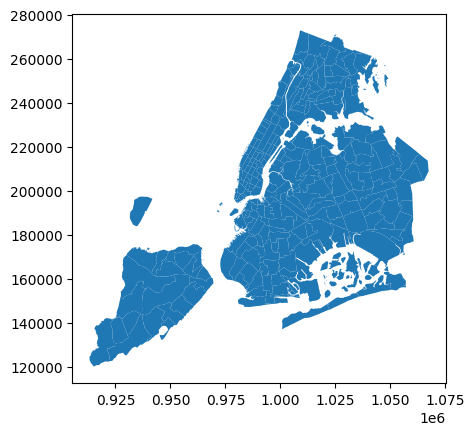

In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the shapefile
gdf = gpd.read_file("./taxi_zones/taxi_zones.shp")

# Plotting
gdf.plot()
plt.show()

# 4. Impact, Usage & Geospacial Analysis

In [44]:
# Yellow cabs by pickup location
from pyspark.sql.functions import hour, count
import plotly.graph_objects as go

# Group by pickup hour and count
hourly_counts = yellow_cab_df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                             .groupBy("pickup_hour") \
                             .count() \
                             .orderBy("pickup_hour") \
                             .collect()

# Separate the results into two lists for plotting
hours = [row['pickup_hour'] for row in hourly_counts]
counts = [row['count'] for row in hourly_counts]

# Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(x=hours, y=counts)
])

# Update the layout
fig.update_layout(
    title="Yellow Cab Trip Counts by Pickup Hour",
    xaxis_title="Hour of Day",
    yaxis_title="Number of Trips",
)

# Show the plot
fig.show()

In [45]:
# green cabs by pickup location
from pyspark.sql.functions import hour, count
import plotly.graph_objects as go

# Group by pickup hour and count
hourly_counts = green_cab_df.withColumn("pickup_hour", hour("lpep_pickup_datetime")) \
                             .groupBy("pickup_hour") \
                             .count() \
                             .orderBy("pickup_hour") \
                             .collect()

# Separate the results into two lists for plotting
hours = [row['pickup_hour'] for row in hourly_counts]
counts = [row['count'] for row in hourly_counts]

# Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(x=hours, y=counts)
])

# Update the layout
fig.update_layout(
    title="Green Cab Trip Counts by Pickup Hour",
    xaxis_title="Hour of Day",
    yaxis_title="Number of Trips",
)

# Show the plot
fig.show()

In [96]:
# fhvhv cabs by pickup location
from pyspark.sql.functions import hour, count
import plotly.graph_objects as go

# Group by pickup hour and count
hourly_counts = uber_lyft_cab_df.withColumn("pickup_hour", hour("pickup_datetime")) \
                             .groupBy("pickup_hour") \
                             .count() \
                             .orderBy("pickup_hour") \
                             .collect()

# Separate the results into two lists for plotting
hours = [row['pickup_hour'] for row in hourly_counts]
counts = [row['count'] for row in hourly_counts]

# Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(x=hours, y=counts)
])

# Update the layout
fig.update_layout(
    title="Uber/Lyft Cab Trip Counts by Pickup Hour",
    xaxis_title="Hour of Day",
    yaxis_title="Number of Trips",
)

# Show the plot
fig.show()

In [97]:
# average fare amount by passenger count in yellow cabs
from pyspark.sql.functions import avg
import plotly.graph_objects as go

# Calculate the average tip amount by passenger count
avg_tip_by_passenger = yellow_cab_df.groupBy("passenger_count") \
                                    .agg(avg("tip_amount").alias("avg_tip")) \
                                    .orderBy("passenger_count") \
                                    .collect()

# Separate the results into two lists for plotting
passenger_counts = [row['passenger_count'] for row in avg_tip_by_passenger]
avg_tips = [row['avg_tip'] for row in avg_tip_by_passenger]

# Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(x=passenger_counts, y=avg_tips)
])

# Update the layout
fig.update_layout(
    title="Average Tip Amount by Passenger Count in Yellow Cabs",
    xaxis_title="Passenger Count",
    yaxis_title="Average Tip Amount ($)",
)

# Show the plot
fig.show()

In [99]:
# average fare amount by passenger count in green cabs
from pyspark.sql.functions import avg
import plotly.graph_objects as go

# Calculate the average tip amount by passenger count
avg_tip_by_passenger = green_cab_df.groupBy("passenger_count") \
                                    .agg(avg("tip_amount").alias("avg_tip")) \
                                    .orderBy("passenger_count") \
                                    .collect()

# Separate the results into two lists for plotting
passenger_counts = [row['passenger_count'] for row in avg_tip_by_passenger]
avg_tips = [row['avg_tip'] for row in avg_tip_by_passenger]

# Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(x=passenger_counts, y=avg_tips)
])

# Update the layout
fig.update_layout(
    title="Average Tip Amount by Passenger Count in Green Cabs",
    xaxis_title="Passenger Count",
    yaxis_title="Average Tip Amount ($)",
)

# Show the plot
fig.show()

In [101]:
uber_lyft_cab_df.show(10)

+-----------------+--------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+---------+--------------------+-----------+----+----------+----------------------+----------------------+-----------+-----------+-----------+------------------+------------------+------------------+-----------------+------------------+
|hvfhs_license_num|dispatching_base_num|   request_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|trip_duration_category|trip_distance_category|pickup_hour|time_of_day|day_of_week| earnings_per_mile| earnings_per_hour|          expenses|    profit_margin|      total_amount|
+-----------------+--------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+---------

In [46]:
# Definning the schema of the dataframe
schema = StructType([
    StructField("LocationID", IntegerType(), True),
    StructField("Borough", StringType(), True),
    StructField("Zone", StringType(), True),
    StructField("service_zone", StringType(), True)
])

# Load the CSV file
taxi_zone_lookup_df = spark.read.csv(
    "taxi_zones/taxi+_zone_lookup.csv",
    header=True,  # Assumes the first row is a header
    schema=schema  # Use the defined schema
)

# Showing the first few rows of the DataFrame
taxi_zone_lookup_df.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [39]:
# top 10 pickup locations by average fare amount in yellow cabs
from pyspark.sql.functions import max, min, avg
import plotly.graph_objects as go

# Step 1: Aggregate fare amount by PULocationID
fare_stats_df = yellow_cab_df.groupBy("PULocationID") \
                             .agg(max("fare_amount").alias("max_fare"),
                                  min("fare_amount").alias("min_fare"),
                                  avg("fare_amount").alias("avg_fare"))

# Step 2: Join with taxi_zone_lookup_df
joined_df = fare_stats_df.join(taxi_zone_lookup_df, fare_stats_df.PULocationID == taxi_zone_lookup_df.LocationID, "inner")

# Step 3: Select top 10 locations based on highest average fare
top_10_locations = joined_df.orderBy("avg_fare", ascending=False).limit(10)

# Collect the data for plotting
top_10_data = top_10_locations.collect()

# Separate the results into lists for plotting
zones = [row['Zone'] for row in top_10_data]
max_fares = [row['max_fare'] for row in top_10_data]
min_fares = [row['min_fare'] for row in top_10_data]
avg_fares = [row['avg_fare'] for row in top_10_data]

# Step 4: Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(name='Max Fare', x=zones, y=max_fares),
    go.Bar(name='Min Fare', x=zones, y=min_fares),
    go.Bar(name='Avg Fare', x=zones, y=avg_fares)
])

# Update the layout
fig.update_layout(
    title="Top 10 PickUP Locations by Average Fare Amount (Yellow Cabs)",
    xaxis_title="Zone",
    yaxis_title="Fare Amount ($)",
    barmode='group'
)

# Show the plot
fig.show()

In [40]:
# top 10 pickup locations by average fare amount in green cabs
from pyspark.sql.functions import max, min, avg
import plotly.graph_objects as go

# Step 1: Aggregate fare amount by PULocationID
fare_stats_df = green_cab_df.groupBy("PULocationID") \
                             .agg(max("fare_amount").alias("max_fare"),
                                  min("fare_amount").alias("min_fare"),
                                  avg("fare_amount").alias("avg_fare"))

# Step 2: Join with taxi_zone_lookup_df
joined_df = fare_stats_df.join(taxi_zone_lookup_df, fare_stats_df.PULocationID == taxi_zone_lookup_df.LocationID, "inner")

# Step 3: Select top 10 locations based on highest average fare
top_10_locations = joined_df.orderBy("avg_fare", ascending=False).limit(10)

# Collect the data for plotting
top_10_data = top_10_locations.collect()

# Separate the results into lists for plotting
zones = [row['Zone'] for row in top_10_data]
max_fares = [row['max_fare'] for row in top_10_data]
min_fares = [row['min_fare'] for row in top_10_data]
avg_fares = [row['avg_fare'] for row in top_10_data]

# Step 4: Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(name='Max Fare', x=zones, y=max_fares),
    go.Bar(name='Min Fare', x=zones, y=min_fares),
    go.Bar(name='Avg Fare', x=zones, y=avg_fares)
])

# Update the layout
fig.update_layout(
    title="Top 10 PickUP Locations by Average Fare Amount (Green Cabs)",
    xaxis_title="Zone",
    yaxis_title="Fare Amount ($)",
    barmode='group'
)

# Show the plot
fig.show()

In [42]:
# top 10 pickup locations by average fare amount in uber_lyft cabs
from pyspark.sql.functions import max, min, avg
import plotly.graph_objects as go

# Summing up the total fare amount for each taxi type
uber_lyft_cab_df = uber_lyft_cab_df.withColumn(
    "total_amount", 
    col("base_passenger_fare") + col("tolls") + col("sales_tax") + 
    col("congestion_surcharge") + col("airport_fee") + col("tips")
)

# Step 1: Aggregate fare amount by PULocationID
fare_stats_df = uber_lyft_cab_df.groupBy("PULocationID") \
                             .agg(max("total_amount").alias("max_fare"),
                                  min("total_amount").alias("min_fare"),
                                  avg("total_amount").alias("avg_fare"))

# Step 2: Join with taxi_zone_lookup_df
joined_df = fare_stats_df.join(taxi_zone_lookup_df, fare_stats_df.PULocationID == taxi_zone_lookup_df.LocationID, "inner")

# Step 3: Select top 10 locations based on highest average fare
top_10_locations = joined_df.orderBy("avg_fare", ascending=False).limit(10)

# Collect the data for plotting
top_10_data = top_10_locations.collect()

# Separate the results into lists for plotting
zones = [row['Zone'] for row in top_10_data]
max_fares = [row['max_fare'] for row in top_10_data]
min_fares = [row['min_fare'] for row in top_10_data]
avg_fares = [row['avg_fare'] for row in top_10_data]

# Step 4: Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(name='Max Fare', x=zones, y=max_fares),
    go.Bar(name='Min Fare', x=zones, y=min_fares),
    go.Bar(name='Avg Fare', x=zones, y=avg_fares)
])

# Update the layout
fig.update_layout(
    title="Top 10 PickUP Locations by Average Fare Amount (Uber/Lyft Cabs)",
    xaxis_title="Zone",
    yaxis_title="Fare Amount ($)",
    barmode='group'
)

# Show the plot
fig.show()

In [47]:
# top 10 dropoff locations by average fare amount in yellow cabs 
from pyspark.sql.functions import max, min, avg
import plotly.graph_objects as go

# Step 1: Aggregate fare amount by PULocationID
fare_stats_df = yellow_cab_df.groupBy("DOLocationID") \
                             .agg(max("fare_amount").alias("max_fare"),
                                  min("fare_amount").alias("min_fare"),
                                  avg("fare_amount").alias("avg_fare"))

# Step 2: Join with taxi_zone_lookup_df
joined_df = fare_stats_df.join(taxi_zone_lookup_df, fare_stats_df.DOLocationID == taxi_zone_lookup_df.LocationID, "inner")

# Step 3: Select top 10 locations based on highest average fare
top_10_locations = joined_df.orderBy("avg_fare", ascending=False).limit(10)

# Collect the data for plotting
top_10_data = top_10_locations.collect()

# Separate the results into lists for plotting
zones = [row['Zone'] for row in top_10_data]
max_fares = [row['max_fare'] for row in top_10_data]
min_fares = [row['min_fare'] for row in top_10_data]
avg_fares = [row['avg_fare'] for row in top_10_data]

# Step 4: Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(name='Max Fare', x=zones, y=max_fares),
    go.Bar(name='Min Fare', x=zones, y=min_fares),
    go.Bar(name='Avg Fare', x=zones, y=avg_fares)
])

# Update the layout
fig.update_layout(
    title="Top 10 DropOff Locations by Average Fare Amount (Yellow Cabs)",
    xaxis_title="Zone",
    yaxis_title="Fare Amount ($)",
    barmode='group'
)

# Show the plot
fig.show()

In [48]:
# top 10 dropoff locations by average fare amount in green cabs
from pyspark.sql.functions import max, min, avg
import plotly.graph_objects as go

# Step 1: Aggregate fare amount by PULocationID
fare_stats_df = green_cab_df.groupBy("DOLocationID") \
                             .agg(max("fare_amount").alias("max_fare"),
                                  min("fare_amount").alias("min_fare"),
                                  avg("fare_amount").alias("avg_fare"))

# Step 2: Join with taxi_zone_lookup_df
joined_df = fare_stats_df.join(taxi_zone_lookup_df, fare_stats_df.DOLocationID == taxi_zone_lookup_df.LocationID, "inner")

# Step 3: Select top 10 locations based on highest average fare
top_10_locations = joined_df.orderBy("avg_fare", ascending=False).limit(10)

# Collect the data for plotting
top_10_data = top_10_locations.collect()

# Separate the results into lists for plotting
zones = [row['Zone'] for row in top_10_data]
max_fares = [row['max_fare'] for row in top_10_data]
min_fares = [row['min_fare'] for row in top_10_data]
avg_fares = [row['avg_fare'] for row in top_10_data]

# Step 4: Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(name='Max Fare', x=zones, y=max_fares),
    go.Bar(name='Min Fare', x=zones, y=min_fares),
    go.Bar(name='Avg Fare', x=zones, y=avg_fares)
])

# Update the layout
fig.update_layout(
    title="Top 10 DropOff Locations by Average Fare Amount (Green Cabs)",
    xaxis_title="Zone",
    yaxis_title="Fare Amount ($)",
    barmode='group'
)

# Show the plot
fig.show()

In [49]:
# top 10 dropoff locations by average fare amount in uber_lyft cabs
from pyspark.sql.functions import max, min, avg
import plotly.graph_objects as go

# Summing up the total fare amount for each taxi type
uber_lyft_cab_df = uber_lyft_cab_df.withColumn(
    "total_amount", 
    col("base_passenger_fare") + col("tolls") + col("sales_tax") + 
    col("congestion_surcharge") + col("airport_fee") + col("tips")
)

# Step 1: Aggregate fare amount by PULocationID
fare_stats_df = uber_lyft_cab_df.groupBy("DOLocationID") \
                             .agg(max("total_amount").alias("max_fare"),
                                  min("total_amount").alias("min_fare"),
                                  avg("total_amount").alias("avg_fare"))

# Step 2: Join with taxi_zone_lookup_df
joined_df = fare_stats_df.join(taxi_zone_lookup_df, fare_stats_df.DOLocationID == taxi_zone_lookup_df.LocationID, "inner")

# Step 3: Select top 10 locations based on highest average fare
top_10_locations = joined_df.orderBy("avg_fare", ascending=False).limit(10)

# Collect the data for plotting
top_10_data = top_10_locations.collect()

# Separate the results into lists for plotting
zones = [row['Zone'] for row in top_10_data]
max_fares = [row['max_fare'] for row in top_10_data]
min_fares = [row['min_fare'] for row in top_10_data]
avg_fares = [row['avg_fare'] for row in top_10_data]

# Step 4: Create the Plotly plot
fig = go.Figure(data=[
    go.Bar(name='Max Fare', x=zones, y=max_fares),
    go.Bar(name='Min Fare', x=zones, y=min_fares),
    go.Bar(name='Avg Fare', x=zones, y=avg_fares)
])

# Update the layout
fig.update_layout(
    title="Top 10 DropOff Locations by Average Fare Amount (Uber/Lyft Cabs)",
    xaxis_title="Zone",
    yaxis_title="Fare Amount ($)",
    barmode='group'
)

# Show the plot
fig.show()

In [43]:
# average trip distance comparison
from pyspark.sql.functions import avg

# Calculating average trip distance
avg_distance_green = green_cab_df.groupBy().avg('trip_distance').collect()[0][0]
avg_distance_yellow = yellow_cab_df.groupBy().avg('trip_distance').collect()[0][0]
avg_distance_uber_lyft = uber_lyft_cab_df.groupBy().avg('trip_miles').collect()[0][0]

# Preparing data for Plotly
distance_data = {'Taxi Type': ['Green', 'Yellow', 'Uber/Lyft'],
                 'Average Distance': [avg_distance_green, avg_distance_yellow, avg_distance_uber_lyft]}
df_distance = pd.DataFrame(distance_data)

# Plotting
fig = px.bar(df_distance, x='Taxi Type', y='Average Distance', title='Average Trip Distance Comparison')
fig.show()

In [45]:
# tips comparison for hours
from pyspark.sql.functions import hour
import plotly.express as px
import plotly.graph_objects as go

# Count trips by hour for each dataframe
green_hourly = green_cab_df.groupBy(hour('lpep_pickup_datetime')).count().orderBy('hour(lpep_pickup_datetime)')
yellow_hourly = yellow_cab_df.groupBy(hour('tpep_pickup_datetime')).count().orderBy('hour(tpep_pickup_datetime)')
uber_lyft_hourly = uber_lyft_cab_df.groupBy(hour('pickup_datetime')).count().orderBy('hour(pickup_datetime)')

# Create lists from the collected data
green_hourly_data = green_hourly.collect()
yellow_hourly_data = yellow_hourly.collect()
uber_lyft_hourly_data = uber_lyft_hourly.collect()

# Create a Plotly figure
fig = go.Figure()

# Add traces for Green, Yellow, and Uber/Lyft data
fig.add_trace(go.Scatter(x=[row['hour(lpep_pickup_datetime)'] for row in green_hourly_data],
                         y=[row['count'] for row in green_hourly_data],
                         mode='lines',
                         name='Green'))
fig.add_trace(go.Scatter(x=[row['hour(tpep_pickup_datetime)'] for row in yellow_hourly_data],
                         y=[row['count'] for row in yellow_hourly_data],
                         mode='lines',
                         name='Yellow'))
fig.add_trace(go.Scatter(x=[row['hour(pickup_datetime)'] for row in uber_lyft_hourly_data],
                         y=[row['count'] for row in uber_lyft_hourly_data],
                         mode='lines',
                         name='Uber/Lyft'))

# Update the layout
fig.update_layout(
    title='Trips per Hour',
    xaxis_title='Hour',
    yaxis_title='Count'
)

# Show the plot
fig.show()

In [53]:
yellow_cab_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---------------+----------------+------------------+----------------------+-----------+-----------+-----------+------------------+-----------------+--------+-----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|pickup_datetime|dropoff_datetime|     trip_duration|trip_duration_category|pickup_hour|time_of_day|day_of_week| earnings_per_mile|earnings_per_hour|expenses|    profit_margin|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import plotly.graph_objects as go

# Define the numerical columns for correlation analysis
numerical_columns = ["passenger_count", "trip_distance", "RatecodeID", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "total_amount"]

# Create Vector Assembler to combine numerical columns into a single feature vector
vector_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")

# Calculate the correlation matrix for each dataset
green_cab_matrix = vector_assembler.transform(green_cab_df).select("features").stat.corr("features")
yellow_cab_matrix = vector_assembler.transform(yellow_cab_df).select("features").stat.corr("features")
# uber_lyft_cab_matrix = vector_assembler.transform(uber_lyft_cab_df).select("features").stat.corr("features")

# Create heatmap plots for correlation matrices
def create_heatmap(matrix, title):
    fig = go.Figure(data=go.Heatmap(
        z=matrix.toArray(),
        x=numerical_columns,
        y=numerical_columns,
        colorscale="Viridis"
    ))
    fig.update_layout(title=title)
    return fig

# Create correlation plots for each dataset
green_cab_correlation_plot = create_heatmap(green_cab_matrix, "Green Cab Correlation")
yellow_cab_correlation_plot = create_heatmap(yellow_cab_matrix, "Yellow Cab Correlation")
# uber_lyft_cab_correlation_plot = create_heatmap(uber_lyft_cab_matrix, "Uber/Lyft Cab Correlation")

# Show the plots
green_cab_correlation_plot.show()
yellow_cab_correlation_plot.show()
# uber_lyft_cab_correlation_plot.show()

In [56]:
# Calculate average trip distance by day of the week
avg_trip_distance_by_day = yellow_cab_df.withColumn("day_of_week", dayofweek("tpep_pickup_datetime")) \
    .groupBy("day_of_week") \
    .avg("Trip_distance") \
    .orderBy("day_of_week")



# Extract day of the week and average trip distance values
day_of_week = avg_trip_distance_by_day.select("day_of_week").rdd.flatMap(lambda x: x).collect()
avg_trip_distance = avg_trip_distance_by_day.select("avg(Trip_distance)").rdd.flatMap(lambda x: x).collect()

# Create a line plot
fig = go.Figure(data=go.Scatter(
    x=day_of_week,
    y=avg_trip_distance,
    mode='lines+markers',
    marker=dict(color='blue'),
    text=day_of_week
))

# Set axis labels and plot title
fig.update_xaxes(title_text="Day of the Week")
fig.update_yaxes(title_text="Average Trip Distance (miles)")
fig.update_layout(title="Average Trip Distance by Day of the Week")

# Show the plot
fig.show()


In [59]:
# Calculate average trip distance by day of the week for each dataset
avg_trip_distance_green = green_cab_df.withColumn("day_of_week", dayofweek("lpep_pickup_datetime")) \
    .groupBy("day_of_week") \
    .avg("Trip_distance") \
    .orderBy("day_of_week")

avg_trip_distance_yellow = yellow_cab_df.withColumn("day_of_week", dayofweek("tpep_pickup_datetime")) \
    .groupBy("day_of_week") \
    .avg("Trip_distance") \
    .orderBy("day_of_week")

avg_trip_distance_uber_lyft = uber_lyft_cab_df.withColumn("day_of_week", dayofweek("pickup_datetime")) \
    .groupBy("day_of_week") \
    .avg("trip_miles") \
    .orderBy("day_of_week")

# Extract day of the week and average trip distance values for each dataset
day_of_week_green = avg_trip_distance_green.select("day_of_week").rdd.flatMap(lambda x: x).collect()
avg_trip_distance_green_values = avg_trip_distance_green.select("avg(Trip_distance)").rdd.flatMap(lambda x: x).collect()

day_of_week_yellow = avg_trip_distance_yellow.select("day_of_week").rdd.flatMap(lambda x: x).collect()
avg_trip_distance_yellow_values = avg_trip_distance_yellow.select("avg(Trip_distance)").rdd.flatMap(lambda x: x).collect()

day_of_week_uber_lyft = avg_trip_distance_uber_lyft.select("day_of_week").rdd.flatMap(lambda x: x).collect()
avg_trip_distance_uber_lyft_values = avg_trip_distance_uber_lyft.select("avg(trip_miles)").rdd.flatMap(lambda x: x).collect()

# Create line plots for each dataset
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=day_of_week_green,
    y=avg_trip_distance_green_values,
    mode='lines+markers',
    marker=dict(color='green'),
    name="Green Cab"
))
fig.add_trace(go.Scatter(
    x=day_of_week_yellow,
    y=avg_trip_distance_yellow_values,
    mode='lines+markers',
    marker=dict(color='yellow'),
    name="Yellow Cab"
))
fig.add_trace(go.Scatter(
    x=day_of_week_uber_lyft,
    y=avg_trip_distance_uber_lyft_values,
    mode='lines+markers',
    marker=dict(color='blue'),
    name="Uber/Lyft Cab"
))

# Set axis labels and plot title
fig.update_xaxes(title_text="Day of the Week")
fig.update_yaxes(title_text="Average Trip Distance (miles)")
fig.update_layout(title="Average Trip Distance by Day of the Week for Different Cab Services")

# Show the plot
fig.show()

In [64]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import plotly.graph_objects as go

# Define a function to calculate and plot correlation matrix
def plot_correlation(df, title):
    # Get the list of numerical columns
    numerical_columns = [col for col, dtype in df.dtypes if dtype == "float" or dtype == "int" or dtype == "double" or dtype == "long"]

    # Create Vector Assembler to combine numerical columns into a single feature vector
    vector_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")

    # Combine all numerical columns into a single vector
    assembled_df = vector_assembler.transform(df)

    # Calculate correlations individually for each pair of columns
    correlation_values = {}
    for col1 in numerical_columns:
        correlation_values[col1] = []
        for col2 in numerical_columns:
            correlation = assembled_df.stat.corr(col1, col2)
            correlation_values[col1].append(correlation)

    # Create heatmap plot for the correlation matrix
    fig = go.Figure(data=go.Heatmap(
        z=[correlation_values[col] for col in numerical_columns],
        x=numerical_columns,
        y=numerical_columns,
        colorscale="Viridis"
    ))
    fig.update_layout(title=title)
    return fig

# Create correlation plots for all three datasets
green_cab_correlation_plot = plot_correlation(green_cab_df, "Green Cab Correlation")
yellow_cab_correlation_plot = plot_correlation(yellow_cab_df, "Yellow Cab Correlation")
uber_lyft_cab_correlation_plot = plot_correlation(uber_lyft_cab_df, "Uber/Lyft Cab Correlation")

# Show the plots
green_cab_correlation_plot.show()
yellow_cab_correlation_plot.show()
uber_lyft_cab_correlation_plot.show()

### Main Plots

In [37]:
#total trip count by cab type
import plotly.express as px

# Calculate total trip count for each cab type
cab_types = ['Uber/Lyft', 'Green Cab', 'Yellow Cab']
trip_counts = [uber_lyft_cab_df.count(), green_cab_df.count(), yellow_cab_df.count()]

# Create a bar chart using Plotly
fig = px.bar(x=cab_types, y=trip_counts, labels={'x': 'Cab Type', 'y': 'Trip Count'},
             title='Total Trip Count by Cab Type (From 2019 to 2023-September)')

# Show the plot
fig.show()

In [67]:
# total revenue comparison
from pyspark.sql.functions import sum
import plotly.express as px

# Summing up the total fare amount for each taxi type
uber_lyft_cab_df = uber_lyft_cab_df.withColumn(
    "total_amount", 
    col("base_passenger_fare") + col("tolls") + col("sales_tax") + 
    col("congestion_surcharge") + col("airport_fee") + col("tips")
)
total_revenue_green = green_cab_df.groupBy().sum('total_amount').collect()[0][0]
total_revenue_yellow = yellow_cab_df.groupBy().sum('total_amount').collect()[0][0]
total_revenue_uber_lyft = uber_lyft_cab_df.groupBy().sum('total_amount').collect()[0][0]

# Preparing data for Plotly
revenue_data = {'Taxi Type': ['Green', 'Yellow', 'Uber/Lyft'],
                'Total Revenue': [total_revenue_green, total_revenue_yellow, total_revenue_uber_lyft]}
df_revenue = pd.DataFrame(revenue_data)

# Plotting
fig = px.bar(df_revenue, x='Taxi Type', y='Total Revenue', title='Total Revenue Comparison (from 2019 to 2023 (Sept))')
fig.show()

In [63]:
import plotly.graph_objects as go

# Calculate key metrics for each dataset
# Average Trip Distance
avg_trip_distance_green = green_cab_df.select(avg("Trip_distance")).collect()[0][0]
avg_trip_distance_yellow = yellow_cab_df.select(avg("Trip_distance")).collect()[0][0]
avg_trip_distance_uber_lyft = uber_lyft_cab_df.select(avg("trip_miles")).collect()[0][0]

# Average Fare
avg_fare_green = green_cab_df.select(avg("Total_amount")).collect()[0][0]
avg_fare_yellow = yellow_cab_df.select(avg("total_amount")).collect()[0][0]
avg_fare_uber_lyft = uber_lyft_cab_df.select(avg("base_passenger_fare")).collect()[0][0]

# Average Passenger Count
avg_passenger_count_green = green_cab_df.select(avg("Passenger_count")).collect()[0][0]
avg_passenger_count_yellow = yellow_cab_df.select(avg("Passenger_count")).collect()[0][0]

# Create a bar plot to compare the metrics
fig = go.Figure(data=[
    go.Bar(name="Green Cab", x=["Average Trip Distance", "Average Fare", "Average Passenger Count"],
           y=[avg_trip_distance_green, avg_fare_green, avg_passenger_count_green]),
    go.Bar(name="Yellow Cab", x=["Average Trip Distance", "Average Fare", "Average Passenger Count"],
           y=[avg_trip_distance_yellow, avg_fare_yellow, avg_passenger_count_yellow]),
    go.Bar(name="Uber/Lyft Cab", x=["Average Trip Distance", "Average Fare", "Average Passenger Count"],
           y=[avg_trip_distance_uber_lyft, avg_fare_uber_lyft])
])

# Update the layout of the plot
fig.update_layout(barmode='group', title="Key Metrics Comparison Across Datasets")

# Show the plot
fig.show()

In [64]:
uber_lyft_cab_df.show(10)

+-----------------+--------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+---------+--------------------+-----------+----+----------+----------------------+----------------------+-----------+-----------+-----------+------------------+------------------+------------------+-----------------+
|hvfhs_license_num|dispatching_base_num|   request_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|trip_duration_category|trip_distance_category|pickup_hour|time_of_day|day_of_week| earnings_per_mile| earnings_per_hour|          expenses|    profit_margin|
+-----------------+--------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+---------+--------------------+-----------+----

In [69]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, expr
import plotly.graph_objects as go

uber_lyft_cab_df = uber_lyft_cab_df.withColumn(
    "total_amount", 
    col("base_passenger_fare") + col("tolls") + col("sales_tax") + 
    col("congestion_surcharge") + col("airport_fee") + col("tips")
)

# Define a function to calculate and display descriptive statistics
def calculate_and_display_statistics(df, dataset_name):
    # Calculate descriptive statistics
    statistics_df = df.select(
        mean("Trip_distance").alias("Mean_Trip_Distance"),
        expr("percentile_approx(Trip_distance, 0.5)").alias("Median_Trip_Distance"),
        expr("percentile_approx(Trip_distance, 0.8)").alias("Mode_Trip_Distance"),
        stddev("Trip_distance").alias("Standard_Deviation_Trip_Distance"),
        mean("Total_amount").alias("Mean_Fare_Amount"),
        expr("percentile_approx(Total_amount, 0.5)").alias("Median_Fare_Amount"),
        expr("percentile_approx(Total_amount, 0.8)").alias("Mode_Fare_Amount"),
        stddev("Total_amount").alias("Standard_Deviation_Fare_Amount"),
        mean("trip_duration").alias("Mean_Trip_Duration"),
        expr("percentile_approx(trip_duration, 0.5)").alias("Median_Trip_Duration"),
        expr("percentile_approx(trip_duration, 0.8)").alias("Mode_Trip_Duration"),
        stddev("trip_duration").alias("Standard_Deviation_Trip_Duration")
    ).collect()[0]

    # Create a bar plot to display the statistics
    fig = go.Figure(data=go.Bar(
        x=list(statistics_df.asDict().keys()),
        y=list(statistics_df.asDict().values()),
        text=list(statistics_df.asDict().values()),
        textposition='auto',
        name=dataset_name
    ))
    fig.update_layout(title=f"Descriptive Statistics for {dataset_name}")

    # Show the plot
    fig.show()

# Calculate and display statistics for each dataset
calculate_and_display_statistics(green_cab_df, "Green Cab")

In [70]:
calculate_and_display_statistics(yellow_cab_df, "Yellow Cab")

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [71]:
def calculate_and_display_statistics2(df, dataset_name):
    # Calculate descriptive statistics
    statistics_df = df.select(
        mean("trip_miles").alias("Mean_Trip_Distance"),
        expr("percentile_approx(trip_miles, 0.5)").alias("Median_Trip_Distance"),
        expr("percentile_approx(trip_miles, 0.8)").alias("Mode_Trip_Distance"),
        stddev("trip_miles").alias("Standard_Deviation_Trip_Distance"),
        mean("Total_amount").alias("trip_miles"),
        expr("percentile_approx(Total_amount, 0.5)").alias("Median_Fare_Amount"),
        expr("percentile_approx(Total_amount, 0.8)").alias("Mode_Fare_Amount"),
        stddev("Total_amount").alias("Standard_Deviation_Fare_Amount"),
        mean("trip_time").alias("Mean_Trip_Duration"),
        expr("percentile_approx(trip_time, 0.5)").alias("Median_Trip_Duration"),
        expr("percentile_approx(trip_time, 0.8)").alias("Mode_Trip_Duration"),
        stddev("trip_time").alias("Standard_Deviation_Trip_Duration")
    ).collect()[0]

    # Create a bar plot to display the statistics
    fig = go.Figure(data=go.Bar(
        x=list(statistics_df.asDict().keys()),
        y=list(statistics_df.asDict().values()),
        text=list(statistics_df.asDict().values()),
        textposition='auto',
        name=dataset_name
    ))
    fig.update_layout(title=f"Descriptive Statistics for {dataset_name}")

    # Show the plot
    fig.show()

calculate_and_display_statistics2(uber_lyft_cab_df, "Uber/Lyft Cab")

In [72]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek, month, count
import plotly.graph_objects as go

# Initialize Spark session
spark = SparkSession.builder.appName("TemporalAnalysis").getOrCreate()

# Assuming you have already loaded the dataframes (green_cab_df, yellow_cab_df, and uber_lyft_cab_df)

# Extract relevant temporal features for each dataset
# Green Cab
green_cab_temporal = green_cab_df.select(
    hour("lpep_pickup_datetime").alias("Hour"),
    dayofweek("lpep_pickup_datetime").alias("DayOfWeek"),
    month("lpep_pickup_datetime").alias("Month")
)

# Yellow Cab
yellow_cab_temporal = yellow_cab_df.select(
    hour("tpep_pickup_datetime").alias("Hour"),
    dayofweek("tpep_pickup_datetime").alias("DayOfWeek"),
    month("tpep_pickup_datetime").alias("Month")
)

# Uber/Lyft Cab
uber_lyft_cab_temporal = uber_lyft_cab_df.select(
    hour("pickup_datetime").alias("Hour"),
    dayofweek("pickup_datetime").alias("DayOfWeek"),
    month("pickup_datetime").alias("Month")
)

# Calculate trip frequencies for each temporal feature
# Green Cab
green_cab_hourly_counts = green_cab_temporal.groupBy("Hour").count().orderBy("Hour")
green_cab_day_of_week_counts = green_cab_temporal.groupBy("DayOfWeek").count().orderBy("DayOfWeek")
green_cab_monthly_counts = green_cab_temporal.groupBy("Month").count().orderBy("Month")

# Yellow Cab
yellow_cab_hourly_counts = yellow_cab_temporal.groupBy("Hour").count().orderBy("Hour")
yellow_cab_day_of_week_counts = yellow_cab_temporal.groupBy("DayOfWeek").count().orderBy("DayOfWeek")
yellow_cab_monthly_counts = yellow_cab_temporal.groupBy("Month").count().orderBy("Month")

# Uber/Lyft Cab
uber_lyft_cab_hourly_counts = uber_lyft_cab_temporal.groupBy("Hour").count().orderBy("Hour")
uber_lyft_cab_day_of_week_counts = uber_lyft_cab_temporal.groupBy("DayOfWeek").count().orderBy("DayOfWeek")
uber_lyft_cab_monthly_counts = uber_lyft_cab_temporal.groupBy("Month").count().orderBy("Month")

# Create Plotly plots to display the temporal analysis
# Hourly Analysis
fig_hourly = go.Figure()
fig_hourly.add_trace(go.Scatter(x=green_cab_hourly_counts.select("Hour").rdd.flatMap(lambda x: x).collect(),
                                y=green_cab_hourly_counts.select("count").rdd.flatMap(lambda x: x).collect(),
                                name="Green Cab"))
fig_hourly.add_trace(go.Scatter(x=yellow_cab_hourly_counts.select("Hour").rdd.flatMap(lambda x: x).collect(),
                                y=yellow_cab_hourly_counts.select("count").rdd.flatMap(lambda x: x).collect(),
                                name="Yellow Cab"))
fig_hourly.add_trace(go.Scatter(x=uber_lyft_cab_hourly_counts.select("Hour").rdd.flatMap(lambda x: x).collect(),
                                y=uber_lyft_cab_hourly_counts.select("count").rdd.flatMap(lambda x: x).collect(),
                                name="Uber/Lyft Cab"))
fig_hourly.update_layout(title="Hourly Trip Frequencies")
fig_hourly.update_xaxes(title="Hour of Day")
fig_hourly.update_yaxes(title="Trip Count")

# Show the plots
fig_hourly.show()


23/12/07 18:46:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [73]:
# Day of Week Analysis
fig_day_of_week = go.Figure()
fig_day_of_week.add_trace(go.Bar(x=green_cab_day_of_week_counts.select("DayOfWeek").rdd.flatMap(lambda x: x).collect(),
                                y=green_cab_day_of_week_counts.select("count").rdd.flatMap(lambda x: x).collect(),
                                name="Green Cab"))
fig_day_of_week.add_trace(go.Bar(x=yellow_cab_day_of_week_counts.select("DayOfWeek").rdd.flatMap(lambda x: x).collect(),
                                y=yellow_cab_day_of_week_counts.select("count").rdd.flatMap(lambda x: x).collect(),
                                name="Yellow Cab"))
fig_day_of_week.add_trace(go.Bar(x=uber_lyft_cab_day_of_week_counts.select("DayOfWeek").rdd.flatMap(lambda x: x).collect(),
                                y=uber_lyft_cab_day_of_week_counts.select("count").rdd.flatMap(lambda x: x).collect(),
                                name="Uber/Lyft Cab"))
fig_day_of_week.update_layout(title="Day of Week Trip Frequencies")
fig_day_of_week.update_xaxes(title="Day of Week")
fig_day_of_week.update_yaxes(title="Trip Count")

fig_day_of_week.show()

In [74]:
# Monthly Analysis
fig_monthly = go.Figure()
fig_monthly.add_trace(go.Bar(x=green_cab_monthly_counts.select("Month").rdd.flatMap(lambda x: x).collect(),
                             y=green_cab_monthly_counts.select("count").rdd.flatMap(lambda x: x).collect(),
                             name="Green Cab"))
fig_monthly.add_trace(go.Bar(x=yellow_cab_monthly_counts.select("Month").rdd.flatMap(lambda x: x).collect(),
                             y=yellow_cab_monthly_counts.select("count").rdd.flatMap(lambda x: x).collect(),
                             name="Yellow Cab"))
fig_monthly.add_trace(go.Bar(x=uber_lyft_cab_monthly_counts.select("Month").rdd.flatMap(lambda x: x).collect(),
                             y=uber_lyft_cab_monthly_counts.select("count").rdd.flatMap(lambda x: x).collect(),
                             name="Uber/Lyft Cab"))
fig_monthly.update_layout(title="Monthly Trip Frequencies")
fig_monthly.update_xaxes(title="Month")
fig_monthly.update_yaxes(title="Trip Count")

fig_monthly.show()

In [99]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import plotly.graph_objects as go
# Sample a subset of the data (less than 1% of the complete datasets)
spark = SparkSession.builder.appName("CorrelationAnalysis").getOrCreate()

# Assuming you have already loaded the dataframes (green_cab_df, yellow_cab_df, and uber_lyft_cab_df)

# Sample a subset of the data (less than 1% of the complete datasets)
sample_fraction = 0.01  # Adjust this fraction as needed
green_cab_sampled = green_cab_df.sample(fraction=sample_fraction, seed=42)
yellow_cab_sampled = yellow_cab_df.sample(fraction=sample_fraction, seed=42)

# Handle null values in the Uber/Lyft Cab dataset by filling them with zeros or appropriate values
uber_lyft_cab_df = uber_lyft_cab_df.fillna(0)  # Replace null values with zeros, you can use other appropriate values

uber_lyft_cab_sampled = uber_lyft_cab_df.sample(fraction=sample_fraction, seed=42)

# Select numerical columns for correlation analysis
numerical_columns_green = [col for col, dtype in green_cab_sampled.dtypes if dtype == "float" or dtype == "int"]
numerical_columns_yellow = [col for col, dtype in yellow_cab_sampled.dtypes if dtype == "float" or dtype == "int"]
numerical_columns_uber_lyft = [col for col, dtype in uber_lyft_cab_sampled.dtypes if dtype == "float" or dtype == "int" or dtype == "double" or dtype == "long"]

# Combine numerical columns into a single feature vector
vector_assembler_green = VectorAssembler(inputCols=numerical_columns_green, outputCol="features_green")
vector_assembler_yellow = VectorAssembler(inputCols=numerical_columns_yellow, outputCol="features_yellow")
vector_assembler_uber_lyft = VectorAssembler(inputCols=numerical_columns_uber_lyft, outputCol="features_uber_lyft")

assembled_green = vector_assembler_green.transform(green_cab_sampled)
assembled_yellow = vector_assembler_yellow.transform(yellow_cab_sampled)
assembled_uber_lyft = vector_assembler_uber_lyft.transform(uber_lyft_cab_sampled)

# Calculate the correlation matrix for each dataset
correlation_matrix_green = Correlation.corr(assembled_green, "features_green").head()
correlation_matrix_yellow = Correlation.corr(assembled_yellow, "features_yellow").head()
correlation_matrix_uber_lyft = Correlation.corr(assembled_uber_lyft, "features_uber_lyft").head()

# Extract the correlation matrix values as NumPy arrays
correlation_matrix_values_green = correlation_matrix_green[0].toArray()
correlation_matrix_values_yellow = correlation_matrix_yellow[0].toArray()
correlation_matrix_values_uber_lyft = correlation_matrix_uber_lyft[0].toArray()

# Create Plotly correlation plots
fig_green = go.Figure(data=go.Heatmap(
    z=correlation_matrix_values_green,
    x=numerical_columns_green,
    y=numerical_columns_green,
    colorscale="Viridis"
))
fig_green.update_layout(title="Green Cab Correlation Matrix")

fig_yellow = go.Figure(data=go.Heatmap(
    z=correlation_matrix_values_yellow,
    x=numerical_columns_yellow,
    y=numerical_columns_yellow,
    colorscale="Viridis"
))
fig_yellow.update_layout(title="Yellow Cab Correlation Matrix")

fig_uber_lyft = go.Figure(data=go.Heatmap(
    z=correlation_matrix_values_uber_lyft,
    x=numerical_columns_uber_lyft,
    y=numerical_columns_uber_lyft,
    colorscale="Viridis"
))
fig_uber_lyft.update_layout(title="Uber/Lyft Cab Correlation Matrix")


23/12/07 21:10:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [103]:
print("Green Cab Correlation Matrix:")
for i in range(len(numerical_columns_green)):
    for j in range(len(numerical_columns_green)):
        column_i = numerical_columns_green[i]
        column_j = numerical_columns_green[j]
        correlation = correlation_matrix_values_green[i][j]
        print(f"{column_i} - {column_j}: {correlation}")

Green Cab Correlation Matrix:
VendorID - VendorID: 1.0
VendorID - RatecodeID: 0.10751719691629825
VendorID - PULocationID: 0.002144624245800669
VendorID - DOLocationID: -0.001902768486441942
VendorID - passenger_count: 0.06452290982532805
VendorID - payment_type: -0.060997891342942666
VendorID - pickup_hour: 0.0011460117079722556
VendorID - day_of_week: -0.0010805796203499866
RatecodeID - VendorID: 0.10751719691629825
RatecodeID - RatecodeID: 1.0
RatecodeID - PULocationID: 0.06796116922476096
RatecodeID - DOLocationID: 0.012249853745093742
RatecodeID - passenger_count: -0.07988789789779345
RatecodeID - payment_type: -0.17783037427008258
RatecodeID - pickup_hour: -0.07655825503600495
RatecodeID - day_of_week: -0.0185576587077184
PULocationID - VendorID: 0.002144624245800669
PULocationID - RatecodeID: 0.06796116922476096
PULocationID - PULocationID: 1.0
PULocationID - DOLocationID: 0.1413140576686935
PULocationID - passenger_count: -0.0021778516865950306
PULocationID - payment_type: -0.0

In [104]:
print("\nYellow Cab Correlation Matrix:")
for i in range(len(numerical_columns_yellow)):
    for j in range(len(numerical_columns_yellow)):
        column_i = numerical_columns_yellow[i]
        column_j = numerical_columns_yellow[j]
        correlation = correlation_matrix_values_yellow[i][j]
        print(f"{column_i} - {column_j}: {correlation}")


Yellow Cab Correlation Matrix:
VendorID - VendorID: 1.0
VendorID - RatecodeID: -0.11914179563334201
VendorID - PULocationID: -0.003421799204626839
VendorID - DOLocationID: 0.0009990555627804594
VendorID - payment_type: -0.0008487153663137656
VendorID - pickup_hour: 0.014523326459236563
VendorID - day_of_week: -0.0008715468676334058
RatecodeID - VendorID: -0.11914179563334201
RatecodeID - RatecodeID: 1.0
RatecodeID - PULocationID: -0.04341811174924157
RatecodeID - DOLocationID: -0.034497572905282076
RatecodeID - payment_type: -0.030919811355948575
RatecodeID - pickup_hour: -0.04162298405510391
RatecodeID - day_of_week: -0.005517982548416518
PULocationID - VendorID: -0.003421799204626839
PULocationID - RatecodeID: -0.04341811174924157
PULocationID - PULocationID: 1.0
PULocationID - DOLocationID: 0.08120460191782487
PULocationID - payment_type: -0.019583123602716305
PULocationID - pickup_hour: 0.011400706245944948
PULocationID - day_of_week: 0.0023992644336809526
DOLocationID - VendorID:

In [105]:
print("\nUber/Lyft Cab Correlation Matrix:")
for i in range(len(numerical_columns_uber_lyft)):
    for j in range(len(numerical_columns_uber_lyft)):
        column_i = numerical_columns_uber_lyft[i]
        column_j = numerical_columns_uber_lyft[j]
        correlation = correlation_matrix_values_uber_lyft[i][j]
        print(f"{column_i} - {column_j}: {correlation}")


Uber/Lyft Cab Correlation Matrix:
trip_miles - trip_miles: 1.0
trip_miles - base_passenger_fare: 0.8552758186426975
trip_miles - tolls: 0.4992465251416682
trip_miles - sales_tax: 0.6404243974533372
trip_miles - congestion_surcharge: 0.02850944867776238
trip_miles - airport_fee: 0.35892217070881827
trip_miles - tips: 0.2346354328725561
trip_miles - driver_pay: 0.8685715256953394
trip_miles - pickup_hour: -0.043117008127050674
trip_miles - day_of_week: -0.015097260082479948
trip_miles - earnings_per_mile: -0.04140935490494025
trip_miles - earnings_per_hour: -0.012037247389753382
trip_miles - expenses: 0.6656174204486166
trip_miles - profit_margin: -0.07084612763224434
trip_miles - total_amount: 0.8501411949804888
base_passenger_fare - trip_miles: 0.8552758186426975
base_passenger_fare - base_passenger_fare: 1.0
base_passenger_fare - tolls: 0.46825577828431475
base_passenger_fare - sales_tax: 0.7689369706003828
base_passenger_fare - congestion_surcharge: 0.13971222435972658
base_passenge

23/12/08 00:00:06 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 287723 ms exceeds timeout 120000 ms
23/12/08 00:00:06 WARN SparkContext: Killing executors is not supported by current scheduler.
23/12/08 00:00:36 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [92]:
fig_green.show()

In [93]:
fig_yellow.show()


# 5. Model Exploration

In [19]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Sampling a subset of the dataset (0.0001% of 900 million)
sampled_df = yellow_cab_df.sample(fraction=0.000001)
print("Number of rows in sampled dataset: ", sampled_df.count())

Number of rows in sampled dataset:  183


In [20]:

feature_columns = ['trip_distance', 'fare_amount', 'trip_duration']

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define KMeans model
kmeans = KMeans(featuresCol="scaled_features", k=3)

# Set up the pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# Fit the model
model = pipeline.fit(sampled_df)

# Transform the dataset
clustered_df = model.transform(sampled_df)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=2072576Kb used=59988Kb max_used=60244Kb free=2012588Kb
 bounds [0x0000000280000000, 0x0000000283bc0000, 0x00000002fe800000]
 total_blobs=17916 nmethods=16899 adapters=928
 compilation: disabled (not enough contiguous free space left)


23/12/06 23:43:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [24]:
clustered_df.show(10)

23/12/06 23:37:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---------------+----------------+------------------+----------------------+-----------+-----------+-----------+------------------+------------------+--------+-----------------+--------------------+--------------------+----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|pickup_datetime|dropoff_datetime|     trip_duration|trip_duration_category|pickup_hour|time_of_day|day_of_week| earnings_per_mile| earnings_per_hour|expenses|    profit_margin|            features|     scaled_features|prediction|
+--------+--------------

In [21]:
# Collect the data for plotting (convert to Pandas DataFrame)
plot_df = clustered_df.select('scaled_features', 'prediction').toPandas()

In [22]:
import plotly.express as px

fig = px.scatter(plot_df, x='scaled_features', y='prediction', color='prediction')

# Update layout if needed
fig.update_layout(title='K-Means Clusters', xaxis_title='Scaled Features', yaxis_title='Prediction')

# Show the plot
fig.show()


In [19]:
sample_fraction = 0.002  # 0.0001% of the dataset
sampled_df = yellow_cab_df.sample(withReplacement=False, fraction=sample_fraction)

# Collecting the data to Pandas DataFrame (ensure this fits in your local memory)
pandas_df = sampled_df.toPandas()

23/12/07 00:09:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=2072576Kb used=58121Kb max_used=58183Kb free=2014454Kb
 bounds [0x0000000280000000, 0x0000000283910000, 0x00000002fe800000]
 total_blobs=16997 nmethods=16004 adapters=904
 compilation: disabled (not enough contiguous free space left)


In [20]:
pandas_df.count()

VendorID                  363103
tpep_pickup_datetime      363103
tpep_dropoff_datetime     363103
passenger_count           363103
trip_distance             363103
RatecodeID                363103
store_and_fwd_flag        363103
PULocationID              363103
DOLocationID              363103
payment_type              363103
fare_amount               363103
extra                     363103
mta_tax                   363103
tip_amount                363103
tolls_amount              363103
improvement_surcharge     363103
total_amount              363103
congestion_surcharge      363103
pickup_datetime           363103
dropoff_datetime          363103
trip_duration             363103
trip_duration_category    363103
pickup_hour               363103
time_of_day               363103
day_of_week               363103
earnings_per_mile         363103
earnings_per_hour         363096
expenses                  363103
profit_margin             363103
dtype: int64

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [22]:
features = pandas_df[['trip_distance', 'fare_amount', 'passenger_count', 'trip_duration', 'payment_type', 'total_amount']]
target = pandas_df['trip_duration_category']

# Convert categorical target into numerical
target = target.factorize()[0]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9909300382811137

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      9259
           1       0.99      1.00      1.00     90489
           2       0.96      0.93      0.95      9183

    accuracy                           0.99    108931
   macro avg       0.98      0.97      0.97    108931
weighted avg       0.99      0.99      0.99    108931



23/12/07 00:34:16 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 181188 ms exceeds timeout 120000 ms
23/12/07 00:34:16 WARN SparkContext: Killing executors is not supported by current scheduler.
23/12/07 00:34:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [23]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Sampling a subset of the dataset (e.g., 0.0001% of 900 million)
sample_fraction = 0.001  # Adjust this based on your needs
sampled_df = yellow_cab_df.sample(withReplacement=False, fraction=sample_fraction)

# Define the features and the target variable
feature_columns = ['trip_distance', 'fare_amount', 'passenger_count']
target_column = 'trip_duration'

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define RandomForest Regressor
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol=target_column)

# Set up the pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Split the data into training and test sets
train_data, test_data = sampled_df.randomSplit([0.7, 0.3])

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 42.9362


In [27]:
yellow_cab_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---------------+----------------+------------------+----------------------+-----------+-----------+-----------+------------------+-----------------+--------+-----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|pickup_datetime|dropoff_datetime|     trip_duration|trip_duration_category|pickup_hour|time_of_day|day_of_week| earnings_per_mile|earnings_per_hour|expenses|    profit_margin|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Feature engineering
yellow_cab_df =yellow_cab_df.withColumn("hour_of_day", hour(col("tpep_pickup_datetime")))
yellow_cab_df =yellow_cab_df.withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))

# Define your categories based on trip duration
def categorize_trip(duration):
    if duration <= 15:
        return 'short'
    elif duration <= 60:
        return 'medium'
    else:
        return 'long'

# Register UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
categorize_trip_udf = udf(categorize_trip, StringType())
yellow_cab_df =yellow_cab_df.withColumn("trip_category", categorize_trip_udf("trip_duration"))

# String Indexing for categorical variables
indexer = StringIndexer(inputCol="trip_category", outputCol="trip_category_indexed")

# VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=["hour_of_day", "day_of_week", "passenger_count", "trip_distance"], outputCol="features")

# StandardScaler to scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# RandomForestClassifier
rf = RandomForestClassifier(labelCol="trip_category_indexed", featuresCol="scaled_features")

# Set up the pipeline
pipeline = Pipeline(stages=[indexer, assembler, scaler, rf])

# Split the data into training and test sets
train_data, test_data =yellow_cab_df.randomSplit([0.7, 0.3])

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="trip_category_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


23/12/07 02:50:29 WARN MemoryStore: Not enough space to cache rdd_221_4 in memory! (computed 328.8 MiB so far)
23/12/07 02:50:29 WARN BlockManager: Persisting block rdd_221_4 to disk instead.
23/12/07 02:50:29 WARN MemoryStore: Not enough space to cache rdd_221_3 in memory! (computed 328.8 MiB so far)
23/12/07 02:50:29 WARN BlockManager: Persisting block rdd_221_3 to disk instead.
23/12/07 02:50:29 WARN MemoryStore: Not enough space to cache rdd_221_6 in memory! (computed 328.8 MiB so far)
23/12/07 02:50:29 WARN BlockManager: Persisting block rdd_221_6 to disk instead.
23/12/07 02:50:29 WARN MemoryStore: Not enough space to cache rdd_221_0 in memory! (computed 328.8 MiB so far)
23/12/07 02:50:29 WARN BlockManager: Persisting block rdd_221_0 to disk instead.
23/12/07 02:50:29 WARN MemoryStore: Not enough space to cache rdd_221_5 in memory! (computed 328.8 MiB so far)
23/12/07 02:50:29 WARN MemoryStore: Not enough space to cache rdd_221_1 in memory! (computed 328.8 MiB so far)
23/12/07 0

Accuracy: 0.8479998546803255


In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define your categories based on trip duration
def categorize_trip(duration):
    return 'short' if duration <= 30 else 'long'

# Register UDF for categorization
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
categorize_trip_udf = udf(categorize_trip, StringType())
yellow_cab_df =yellow_cab_df.withColumn("trip_category", categorize_trip_udf("trip_duration"))

# String Indexing for the categorical label
indexer = StringIndexer(inputCol="trip_category", outputCol="label")

# VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=["hour_of_day", "day_of_week", "passenger_count", "trip_distance"], outputCol="features")

# StandardScaler to scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define SVM model
svm = LinearSVC(featuresCol="scaled_features", labelCol="label")

# Set up the pipeline
pipeline = Pipeline(stages=[indexer, assembler, scaler, svm])

# Split the data into training and test sets
train_data, test_data =yellow_cab_df.randomSplit([0.7, 0.3])

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Area Under ROC: {auc}")

23/12/07 03:22:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Area Under ROC: 0.7709037791439917


In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define your categories based on trip duration
def categorize_trip(duration):
    if duration <= 15:
        return 'short'
    elif duration <= 60:
        return 'medium'
    else:
        return 'long'

# Register UDF for categorization
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
categorize_trip_udf = udf(categorize_trip, StringType())
yellow_cab_df = yellow_cab_df.withColumn("trip_category", categorize_trip_udf("trip_duration"))

# String Indexing for the categorical label
indexer = StringIndexer(inputCol="trip_category", outputCol="label")

# VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=["hour_of_day", "day_of_week", "passenger_count", "trip_distance"], outputCol="features")

# Define Naive Bayes model
nb = NaiveBayes(featuresCol="features", labelCol="label")

# Set up the pipeline
pipeline = Pipeline(stages=[indexer, assembler, nb])

# Split the data into training and test sets
train_data, test_data = yellow_cab_df.randomSplit([0.7, 0.3])

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7447219530622423


In [33]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

# Select the features for clustering
vec_assembler = VectorAssembler(inputCols=["passenger_count", "trip_distance", "total_amount"], outputCol="features")
df_kmeans = vec_assembler.transform(yellow_cab_df)

# Define KMeans model
kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol("features")

# Train the model
model = kmeans.fit(df_kmeans)

# Make predictions
predictions = model.transform(df_kmeans)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

23/12/07 04:17:27 WARN MemoryStore: Not enough space to cache rdd_989_25 in memory! (computed 104.8 MiB so far)
23/12/07 04:17:27 WARN BlockManager: Persisting block rdd_989_25 to disk instead.
23/12/07 04:17:27 WARN MemoryStore: Not enough space to cache rdd_989_28 in memory! (computed 104.8 MiB so far)
23/12/07 04:17:27 WARN BlockManager: Persisting block rdd_989_28 to disk instead.
23/12/07 04:17:27 WARN MemoryStore: Not enough space to cache rdd_989_31 in memory! (computed 66.3 MiB so far)
23/12/07 04:17:27 WARN BlockManager: Persisting block rdd_989_31 to disk instead.
23/12/07 04:17:27 WARN MemoryStore: Not enough space to cache rdd_989_27 in memory! (computed 104.8 MiB so far)
23/12/07 04:17:27 WARN BlockManager: Persisting block rdd_989_27 to disk instead.
23/12/07 04:17:27 WARN MemoryStore: Not enough space to cache rdd_989_30 in memory! (computed 104.8 MiB so far)
23/12/07 04:17:27 WARN BlockManager: Persisting block rdd_989_30 to disk instead.
23/12/07 04:17:27 WARN MemorySt

Silhouette with squared euclidean distance = 0.9189130824629944


# Model Exploration Plots

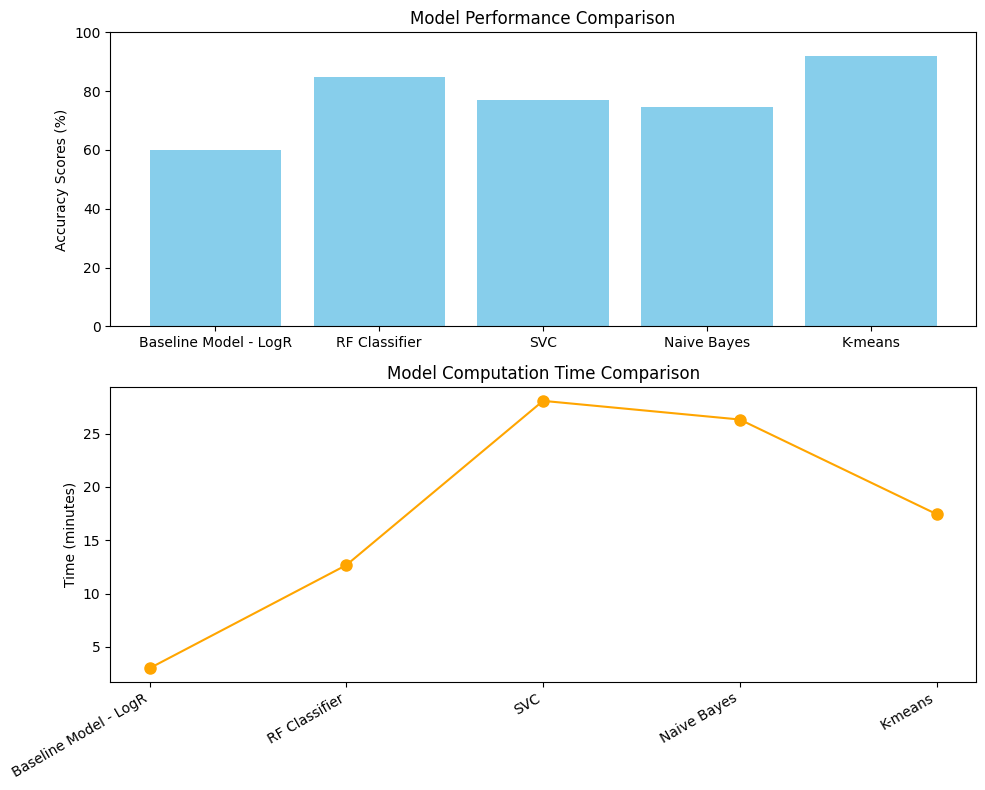

In [82]:
import matplotlib.pyplot as plt

# Model names and their performance scores
models = ['Baseline Model - LogR', 'RF Classifier', 'SVC', 'Naive Bayes', 'K-means']
scores = [60, 84.7, 77.09, 74.47, 91.89]  # Assuming baseline model has an arbitrary score of 60 for demonstration

# Model names and their computation times
times = [3, 12.67, 28.07, 26.32, 17.45]  # Times in minutes

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the histogram of accuracies
ax1.bar(models, scores, color='skyblue')
ax1.set_ylabel('Accuracy Scores (%)')
ax1.set_title('Model Performance Comparison')
ax1.set_ylim(0, 100)

# Plot the line chart of time taken
ax2.plot(models, times, marker='o', color='orange', linestyle='-', markersize=8)
ax2.set_ylabel('Time (minutes)')
ax2.set_title('Model Computation Time Comparison')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=30, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

In [84]:
import plotly.graph_objects as go

# Model names and their performance scores
models = ['Baseline Model - LogR', 'RF Classifier', 'SVC', 'Naive Bayes', 'K-means']
scores = [60, 84.7, 77.09, 74.47, 91.89]  # Assuming baseline model has an arbitrary score of 60 for demonstration

# Model names and their computation times
times = [3, 12.67, 28.07, 26.32, 17.45]  # Times in minutes

# Create a subplot with two traces (bar chart and line chart)
fig = go.Figure()

# Add a bar chart for performance scores
fig.add_trace(go.Bar(
    x=models,
    y=scores,
    name='Accuracy Scores (%)',
    marker_color='skyblue'
))

# Add a line chart for computation times
fig.add_trace(go.Scatter(
    x=models,
    y=times,
    mode='lines+markers',
    name='Time (minutes)',
    line=dict(color='orange', width=2),
    marker=dict(color='orange', size=8)
))

# Customize layout
fig.update_layout(
    title='Model Performance and Computation Time Comparison',
    xaxis_title='Models',
    yaxis=dict(title='Accuracy Scores (%)', range=[0, 100]),
    yaxis2=dict(title='Time (minutes)', overlaying='y', side='right'),
    xaxis=dict(tickangle=30, tickfont=dict(size=12)),
    legend=dict(x=0.7, y=1.15),
    height=600,
    width=800,
)

# Show the plot
fig.show()